# Predicting the Future and Quantifying the Uncertainty

MATH5872M: Dissertation in Data Science and Analytics
as part of the degree of MSc Data Science and Analytics

The University of Leeds, School of Mathematics

Author: Tanakij Jivacharoen

Student ID: 201684567

Supervised by Kurt Langfeld

Appendix D: Gaussian Process Regression using TensorFlow for a Stock Market Data (Alphabet Inc. (GOOG))

September 2023

This implementation dedicates to analyse the behaviours of the Gaussian process regression model using different kernel functions.

The dataset used in this research consists of Alphabet Inc. (GOOG) stock prices.

In this Gaussian process regression implementation, TensorFlow was utilized to construct models and acquire posterior distributions.

# Set Up

In [17]:
# Imports
import os
from itertools import islice
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
import bokeh
import bokeh.io
import bokeh.plotting
import bokeh.models
from IPython.display import display, HTML

bokeh.io.output_notebook(hide_banner=True)

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
psd_kernels = tfp.math.psd_kernels

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Using colab
from google.colab import drive
drive.mount("/content/drive")

# mounted on MyDrive
!ls "/content/drive"

Mounted at /content/drive
MyDrive


In [3]:
# Define your result path in the Mydrive --> avoids re-running the same network after session

# ROOT = ""./"
# Using colab
ROOT = "/content/drive/MyDrive/Dissertation/"

ResultPath = ROOT + "Dataset"

# make these directories if not available
# --> this will avoid you from downloading the data again and again
os.makedirs(ROOT, exist_ok = True)
os.makedirs(ResultPath, exist_ok = True)

# Download the dataset
Or you can obtain the Alphabet Inc. (GOOG) at [Alphabet Inc. (GOOG) Stock Price by Yahoo Finance](https://finance.yahoo.com/quote/GOOG/history?period1=1658102400&period2=1689724800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true).

In [4]:
# Collect the data in the goog_df variable

goog_df = pd.read_csv('/content/drive/MyDrive/Dissertation/Dataset/GOOG.csv')
goog_df

Date        Open        High         Low       Close   Adj Close  \
0    2022-07-18  113.440002  114.800003  109.300003  109.910004  109.910004   
1    2022-07-19  111.730003  114.809998  110.500000  114.620003  114.620003   
2    2022-07-20  114.059998  116.330002  113.260002  114.699997  114.699997   
3    2022-07-21  115.089996  115.209999  111.910004  115.040001  115.040001   
4    2022-07-22  111.809998  113.180000  107.599998  108.360001  108.360001   
..          ...         ...         ...         ...         ...         ...   
247  2023-07-12  119.300003  120.959999  119.000000  119.620003  119.620003   
248  2023-07-13  121.540001  125.334999  121.059998  124.830002  124.830002   
249  2023-07-14  125.129997  127.089996  124.900002  125.699997  125.699997   
250  2023-07-17  126.059998  127.279999  124.500000  125.059998  125.059998   
251  2023-07-18  124.904999  124.989998  123.300003  124.250000  124.250000   

       Volume  
0    33354000  
1    30992300  
2    26780100  
3    27267800  
4    44455300  
..        ...  
247  22059600  
248  31535900  
249  20482800  
250  20655000  
251  14632389  

[252 rows x 7 columns]

It can be seen that the dataset comprises multiple features. When dealing with datasets that have several features, it is common to select a subset of features that are relevant to the specific analysis or modeling task. For the scope of this research, our analysis is centered solely on the 'Date' and 'Close' features.

In [5]:
# Focus on the Date and Close price only

goog = goog_df[['Date', 'Close']]
goog

Date       Close
0    2022-07-18  109.910004
1    2022-07-19  114.620003
2    2022-07-20  114.699997
3    2022-07-21  115.040001
4    2022-07-22  108.360001
..          ...         ...
247  2023-07-12  119.620003
248  2023-07-13  124.830002
249  2023-07-14  125.699997
250  2023-07-17  125.059998
251  2023-07-18  124.250000

[252 rows x 2 columns]

The dataset contains 251 instances. However, Gaussian processes (GPs) are often considered more advantageous for smaller datasets compared to larger ones due to their specific characteristics and capabilities. Therefore, for our analysis, we focus on a window size of 55, with 50 instances used for training and 5 for testing purposes.

In [6]:
# Pick a 55 days time period to be analysed

goog_55 = goog[-55-0*55:]
goog_55

Date       Close
197  2023-04-28  108.220001
198  2023-05-01  107.709999
199  2023-05-02  105.980003
200  2023-05-03  106.120003
201  2023-05-04  105.209999
202  2023-05-05  106.214996
203  2023-05-08  108.239998
204  2023-05-09  107.940002
205  2023-05-10  112.279999
206  2023-05-11  116.900002
207  2023-05-12  117.919998
208  2023-05-15  116.959999
209  2023-05-16  120.089996
210  2023-05-17  121.480003
211  2023-05-18  123.519997
212  2023-05-19  123.250000
213  2023-05-22  125.870003
214  2023-05-23  123.290001
215  2023-05-24  121.639999
216  2023-05-25  124.349998
217  2023-05-26  125.430000
218  2023-05-30  124.639999
219  2023-05-31  123.370003
220  2023-06-01  124.370003
221  2023-06-02  125.230003
222  2023-06-05  126.629997
223  2023-06-06  127.910004
224  2023-06-07  122.940002
225  2023-06-08  122.669998
226  2023-06-09  122.870003
227  2023-06-12  124.349998
228  2023-06-13  124.430000
229  2023-06-14  124.379997
230  2023-06-15  125.790001
231  2023-06-16  124.059998
232  2023-06-20  123.849998
233  2023-06-21  121.260002
234  2023-06-22  123.870003
235  2023-06-23  123.019997
236  2023-06-26  119.089996
237  2023-06-27  119.010002
238  2023-06-28  121.080002
239  2023-06-29  120.010002
240  2023-06-30  120.970001
241  2023-07-03  120.559998
242  2023-07-05  122.629997
243  2023-07-06  120.930000
244  2023-07-07  120.139999
245  2023-07-10  116.870003
246  2023-07-11  117.709999
247  2023-07-12  119.620003
248  2023-07-13  124.830002
249  2023-07-14  125.699997
250  2023-07-17  125.059998
251  2023-07-18  124.250000

In [7]:
goog_55.shape

(55, 2)

In [8]:
# Convert Date to be Index

goog_set = goog_55.set_index('Date')
goog_set = goog_set.reset_index()
goog_set = goog_set.reset_index()
goog_set

index        Date       Close
0       0  2023-04-28  108.220001
1       1  2023-05-01  107.709999
2       2  2023-05-02  105.980003
3       3  2023-05-03  106.120003
4       4  2023-05-04  105.209999
5       5  2023-05-05  106.214996
6       6  2023-05-08  108.239998
7       7  2023-05-09  107.940002
8       8  2023-05-10  112.279999
9       9  2023-05-11  116.900002
10     10  2023-05-12  117.919998
11     11  2023-05-15  116.959999
12     12  2023-05-16  120.089996
13     13  2023-05-17  121.480003
14     14  2023-05-18  123.519997
15     15  2023-05-19  123.250000
16     16  2023-05-22  125.870003
17     17  2023-05-23  123.290001
18     18  2023-05-24  121.639999
19     19  2023-05-25  124.349998
20     20  2023-05-26  125.430000
21     21  2023-05-30  124.639999
22     22  2023-05-31  123.370003
23     23  2023-06-01  124.370003
24     24  2023-06-02  125.230003
25     25  2023-06-05  126.629997
26     26  2023-06-06  127.910004
27     27  2023-06-07  122.940002
28     28  2023-06-08  122.669998
29     29  2023-06-09  122.870003
30     30  2023-06-12  124.349998
31     31  2023-06-13  124.430000
32     32  2023-06-14  124.379997
33     33  2023-06-15  125.790001
34     34  2023-06-16  124.059998
35     35  2023-06-20  123.849998
36     36  2023-06-21  121.260002
37     37  2023-06-22  123.870003
38     38  2023-06-23  123.019997
39     39  2023-06-26  119.089996
40     40  2023-06-27  119.010002
41     41  2023-06-28  121.080002
42     42  2023-06-29  120.010002
43     43  2023-06-30  120.970001
44     44  2023-07-03  120.559998
45     45  2023-07-05  122.629997
46     46  2023-07-06  120.930000
47     47  2023-07-07  120.139999
48     48  2023-07-10  116.870003
49     49  2023-07-11  117.709999
50     50  2023-07-12  119.620003
51     51  2023-07-13  124.830002
52     52  2023-07-14  125.699997
53     53  2023-07-17  125.059998
54     54  2023-07-18  124.250000

In [9]:
goog_close = goog_set[['index', 'Close']]
data = goog_close.to_numpy()
data

array([[  0.      , 108.220001],
       [  1.      , 107.709999],
       [  2.      , 105.980003],
       [  3.      , 106.120003],
       [  4.      , 105.209999],
       [  5.      , 106.214996],
       [  6.      , 108.239998],
       [  7.      , 107.940002],
       [  8.      , 112.279999],
       [  9.      , 116.900002],
       [ 10.      , 117.919998],
       [ 11.      , 116.959999],
       [ 12.      , 120.089996],
       [ 13.      , 121.480003],
       [ 14.      , 123.519997],
       [ 15.      , 123.25    ],
       [ 16.      , 125.870003],
       [ 17.      , 123.290001],
       [ 18.      , 121.639999],
       [ 19.      , 124.349998],
       [ 20.      , 125.43    ],
       [ 21.      , 124.639999],
       [ 22.      , 123.370003],
       [ 23.      , 124.370003],
       [ 24.      , 125.230003],
       [ 25.      , 126.629997],
       [ 26.      , 127.910004],
       [ 27.      , 122.940002],
       [ 28.      , 122.669998],
       [ 29.      , 122.870003],
       [ 3

In [10]:
# Split the dataset into the training set and teat set

train_set = data[:len(data)-5]
test_set = data[-5:]

Now we visualise the original data and standardised data.

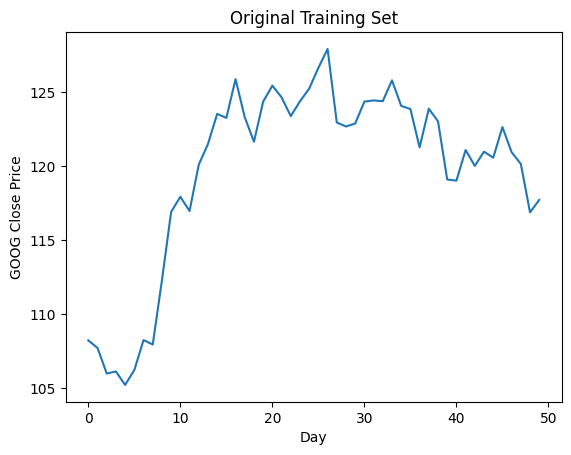

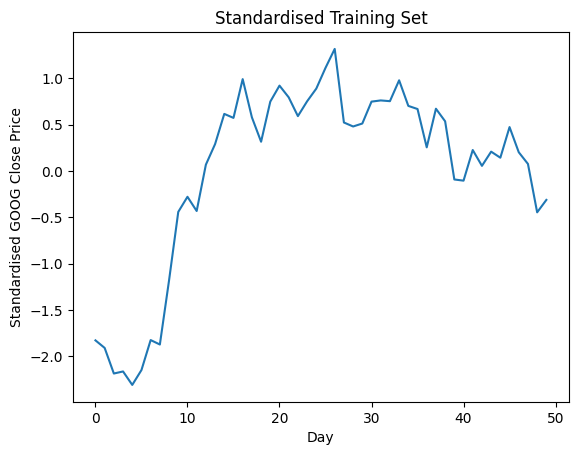

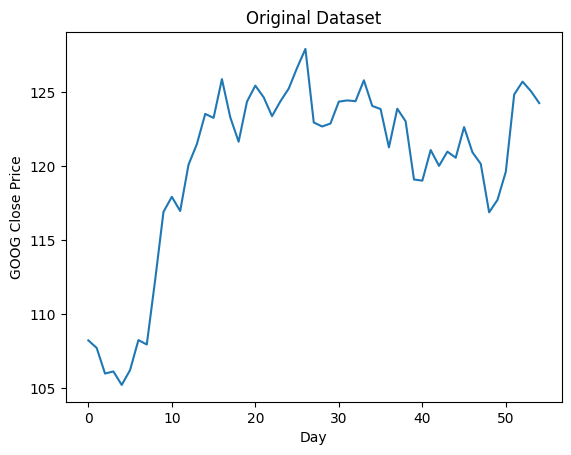

In [11]:
# Plot the data

# Extract X, Y coordinates
x1 = train_set[:, 0]
y1 = train_set[:, 1]

# Extract X, Y coordinates
xt = test_set[:, 0]
yt = test_set[:, 1]

# STNDARDISING THE DATA
av = y1.mean()
std = y1.std()

y2 = (y1-av)/std

# Reshape the data and subtract average from y data
x = np.reshape(x1, (len(np.unique(x1)), 1))
y = np.reshape(y2, (len(np.unique(x1))))

# PLOTTING THE ORIGINAL AND STANDRADISED DATA
# original data
plt.title('Original Training Set')
plt.xlabel('Day')
plt.ylabel('GOOG Close Price')
plt.plot(x,y1)
plt.show()
# standardised data
plt.title('Standardised Training Set')
plt.xlabel('Day')
plt.ylabel('Standardised GOOG Close Price')
plt.plot(x,y2)
plt.show()
# original dataset of size 55
plt.title('Original Dataset')
plt.xlabel('Day')
plt.ylabel('GOOG Close Price')
plt.plot(data[:, 0], data[:, 1])
plt.show()

# Gaussian Process Regression

##Optimize model parameters via maximum marginal likelihood:

In this research, we employed gradient descent, specifically the Adam optimiser, to learn both the kernel parameters and the observation noise variance. This optimization process was conducted on the maximum marginal likelihood.

## Exponentiated Quadratic Kernel without Noise
We first apply the squared exponential kernel without noise to the data.

In [ ]:
tfb = tfp.bijectors
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

Step 0: NLL = 146918.65725339783
Step 100: NLL = 4094.7977650477733
Step 200: NLL = 1386.00973003659
Step 300: NLL = 710.7485892546955
Step 400: NLL = 451.0677177698002
Step 500: NLL = 332.1074156364107
Step 600: NLL = 273.4360164649142
Step 700: NLL = 244.06656480221793
Step 800: NLL = 229.8814309509146
Step 900: NLL = 223.67354236180455
Step 1000: NLL = 221.4433286177604
Step 1100: NLL = 220.88981396201706
Step 1200: NLL = 220.82006818221313
Step 1300: NLL = 220.81745517864903
Step 1400: NLL = 220.96516135010972
Step 1500: NLL = 220.97610726721538
Step 1600: NLL = 220.97826926274135
Step 1700: NLL = 220.9819445643668
Step 1800: NLL = 220.9878547746631
Step 1900: NLL = 220.99578033449836
Final NLL = 220.95238064365535


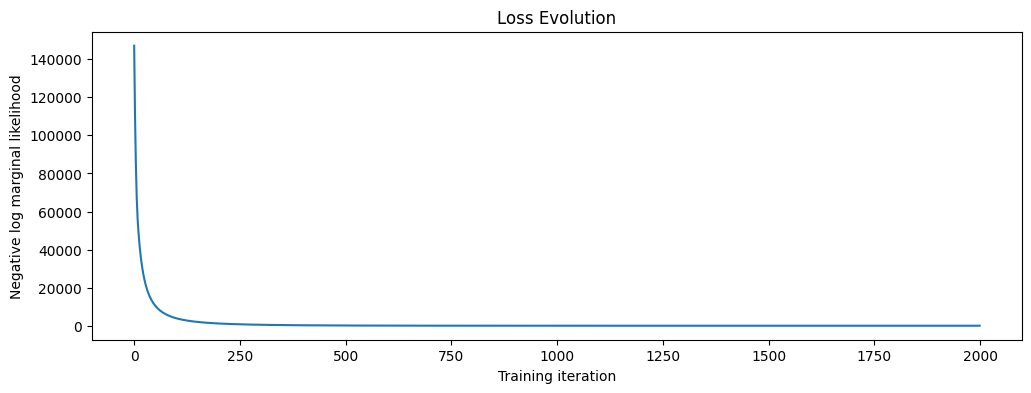

<function matplotlib.pyplot.show(close=None, block=None)>

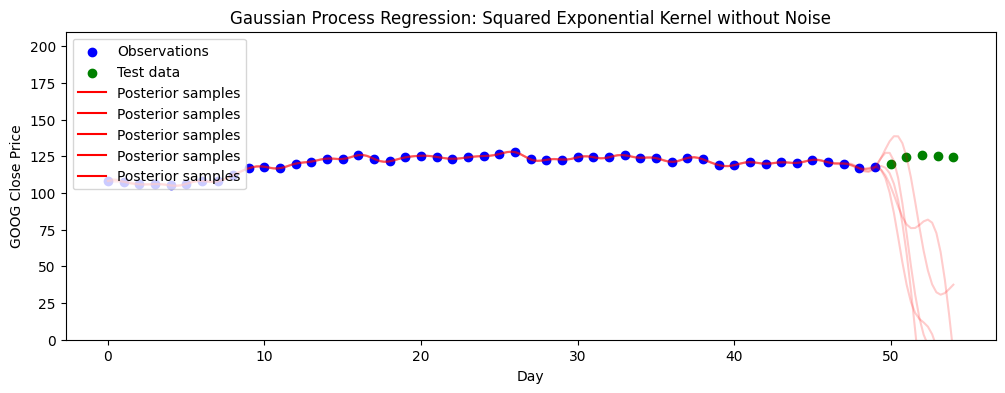

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Noise-free observation
observation_noise_variance = 0.0

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

# The parameters beta_1 and beta_2 are the exponential decay rates for
# the first and second moments of the gradient, respectively.
# They control the weight given to past gradients and squared gradients
# in the parameter updates.
optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential Kernel without Noise')
plt.ylim(0,210)
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
para.append(('observation_noise_variance', np.array(observation_noise_variance)))
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters               Value
0                   amplitude   77.63705517997818
1                length_scale  1.5949670632554211
2  observation_noise_variance                 0.0

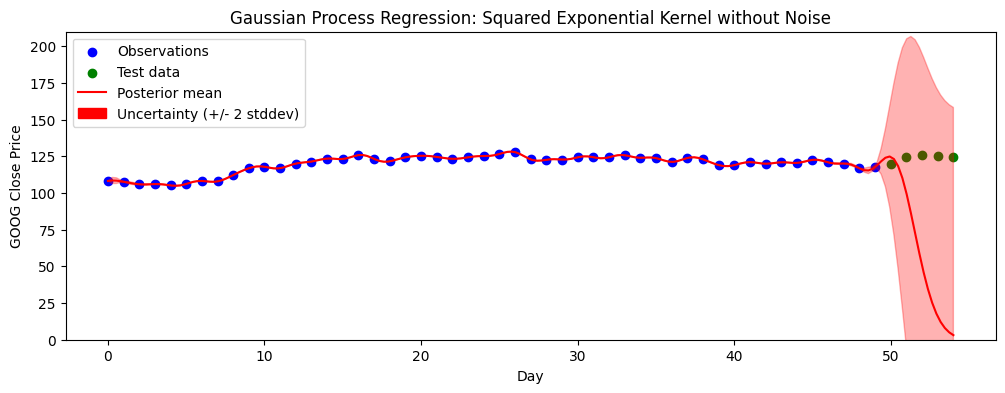

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential Kernel without Noise')
plt.ylim(0,210)
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

The convergence of the posterior mean of the Gaussian process regression model, when employing a squared exponential kernel without noise, can be observed to approach 0 on the test inputs.

Despite the issue, this particular kernel is highly suitable for interpolation tasks, particularly in situations where there are gaps or missing data that need to be imputed or filled.

In [ ]:
posterior_mean_without_noise, posterior_stddev_withou_noise = gprm.mean(), gprm.stddev()

### Standardisation
For regression tasks, a common practice is to standardise or normalise the data before proceeding with model training. Hence, we standardise the observations before applying the Gaussian process.

Step 0: NLL = 43.02427328275826
Step 100: NLL = 37.03900303846184
Step 200: NLL = 37.08178724663915
Step 300: NLL = 37.101911826135805
Step 400: NLL = 37.05691628701156
Step 500: NLL = 37.05160717684676
Step 600: NLL = 37.06056449218585
Step 700: NLL = 37.068326031434594
Step 800: NLL = 37.072719657884754
Step 900: NLL = 37.074902753971884
Step 1000: NLL = 37.07591932118984
Step 1100: NLL = 37.076363102343095
Step 1200: NLL = 37.076539272499076
Step 1300: NLL = 37.07659734711136
Step 1400: NLL = 37.07660755468883
Step 1500: NLL = 37.076601225827844
Step 1600: NLL = 37.076591306358736
Step 1700: NLL = 37.076582451321194
Step 1800: NLL = 37.07657582827218
Step 1900: NLL = 37.076571306495794
Final NLL = 37.08394525352219


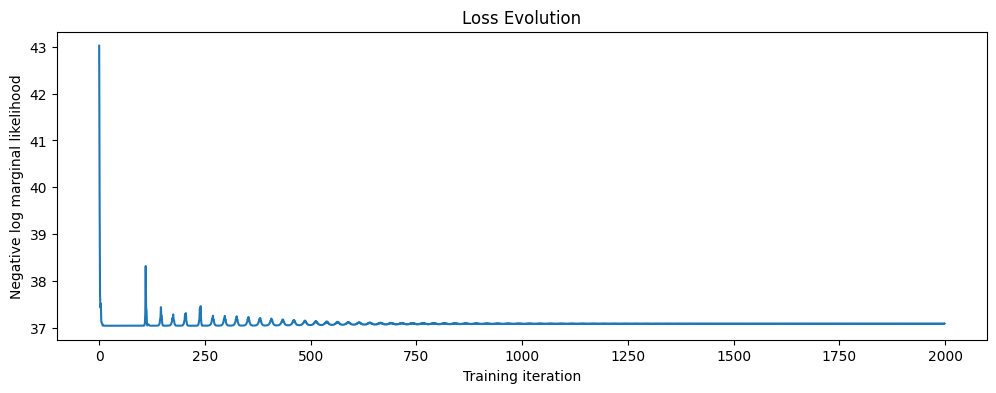

<function matplotlib.pyplot.show(close=None, block=None)>

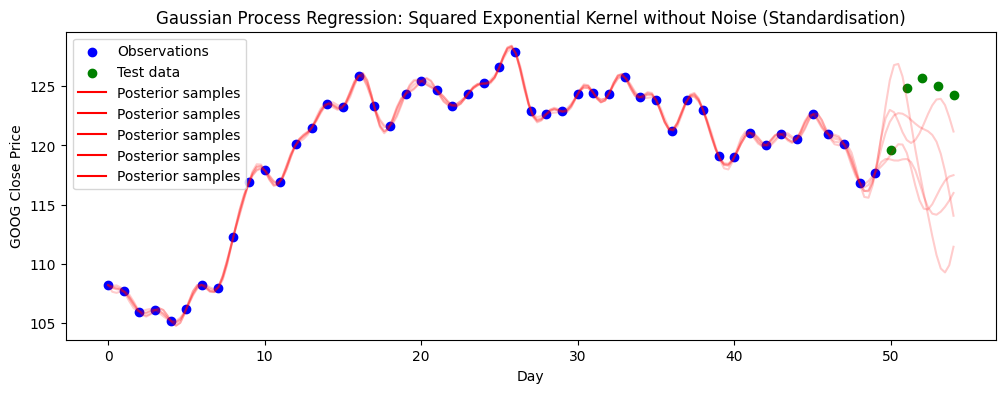

In [22]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y2

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Noise-free observation
observation_noise_variance = 0.0

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

# The parameters beta_1 and beta_2 are the exponential decay rates for
# the first and second moments of the gradient, respectively.
# They control the weight given to past gradients and squared gradients
# in the parameter updates.
optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()*std + av
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential Kernel without Noise (Standardisation)')
plt.scatter(observation_index_points, y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [23]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
para.append(('observation_noise_variance', np.array(observation_noise_variance)))
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters              Value
0                   amplitude  0.801045174429068
1                length_scale  1.115770799142601
2  observation_noise_variance                0.0

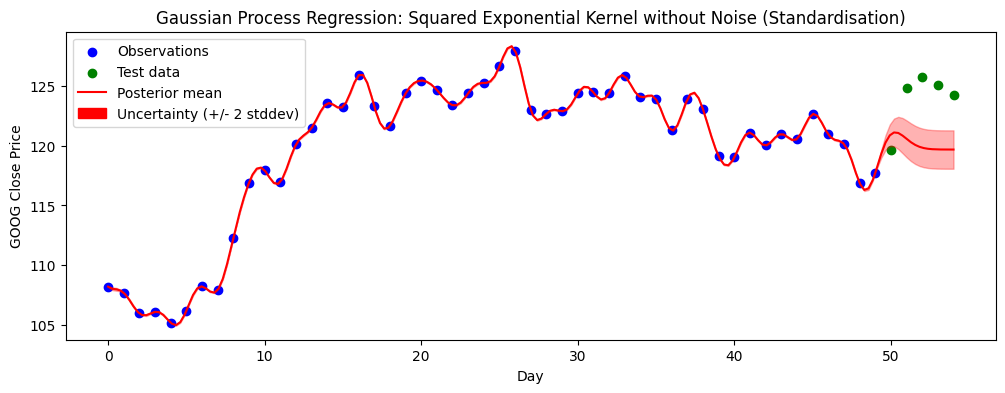

In [24]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean()*std + av, gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential Kernel without Noise (Standardisation)')
plt.scatter(np.squeeze(observation_index_points), y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Now, after conducting 2,000 epochs of training, it is evident that the negative log marginal likelihood value is significantly lower compared to training the model without standardisation. However, it is important to note that the actual test data points (green) still fall outside the confidence band. This observation might indicate a potential issue with overfitting, where the model fits the training data very closely but struggles when it comes to making accurate predictions. Interestingly, even without subtracting the mean of the observations from the data, the posterior mean now converges towards the mean of the observations. This effect could be attributed to standardization, which essentially achieves the similar outcome as subtracting the mean of the observations from the data. Consequently, there is no need to manually perform this subtraction if we standardise our data.

## Exponentiated Quadratic Kernel with Noise
We add noises to the squared exponential kernel and the observations.

Step 0: NLL = 146460.14722449708
Step 100: NLL = 2884.342659334761
Step 200: NLL = 970.2241623763159
Step 300: NLL = 507.33741738355315
Step 400: NLL = 324.77923881701685
Step 500: NLL = 235.47544762314007
Step 600: NLL = 188.22110099686122
Step 700: NLL = 160.8539418934418
Step 800: NLL = 143.61070908397113
Step 900: NLL = 132.71060738298286
Step 1000: NLL = 126.50251555323973
Step 1100: NLL = 123.14336482538681
Step 1200: NLL = 121.44728967247221
Step 1300: NLL = 120.68795240187205
Step 1400: NLL = 120.4138023740195
Step 1500: NLL = 120.34674452694281
Step 1600: NLL = 120.33905822600698
Step 1700: NLL = 120.33835205100473
Step 1800: NLL = 120.338350977564
Step 1900: NLL = 120.33835097752467
Final NLL = 120.33835097759345


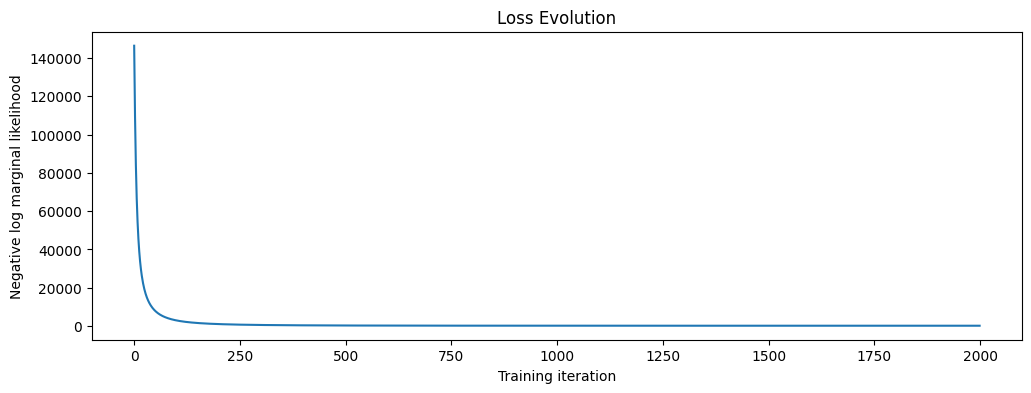

<function matplotlib.pyplot.show(close=None, block=None)>

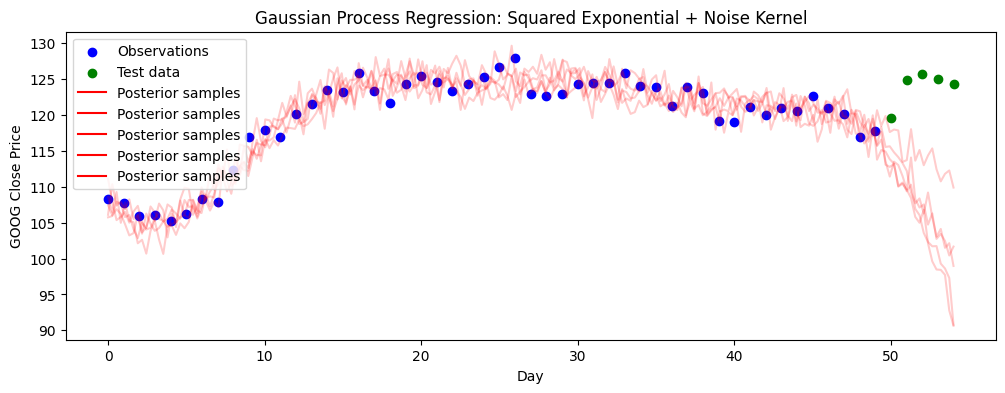

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Noisy observation
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optomised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters               Value
0                   amplitude   96.19470890361733
1                length_scale   13.52374339302624
2  observation_noise_variance  2.1868509023545974

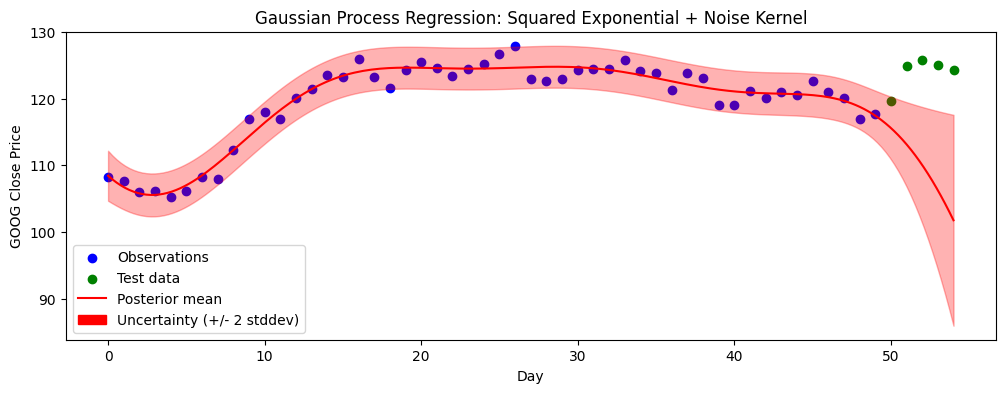

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='lower left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

To gain a more detailed understanding, let's extend the analysis, observing its behavior and the corresponding converging values in further test inputs.

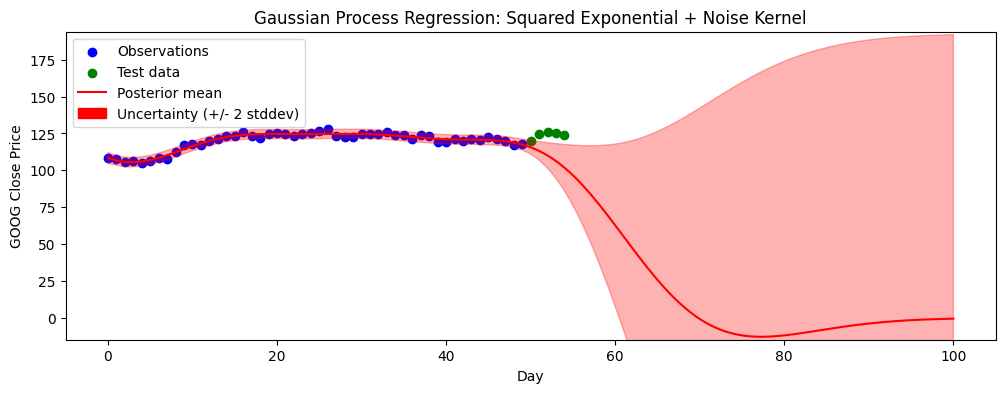

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.ylim(tf.reduce_min(mean_prediction).numpy()-2, tf.reduce_max(mean_prediction + 2 * prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

The figure clearly shows that the posterior mean of the Gaussian process regression model, when employing a squared exponential kernel with noise, also exhibits convergence towards 0 on the test inputs.

### Avoiding the zero mean of the posterior
To prevent the extrapolation from having a zero mean in predictions far into the future, a common approach is to initially subtract the mean of the observations from the data and then reintroduce it after applying the Gaussian process.

In [ ]:
y1_new = y1-y1.mean()
y1_new

array([-11.44509902, -11.95510102, -13.68509702, -13.54509702,
       -14.45510102, -13.45010402, -11.42510202, -11.72509802,
        -7.38510102,  -2.76509802,  -1.74510202,  -2.70510102,
         0.42489598,   1.81490298,   3.85489698,   3.58489998,
         6.20490298,   3.62490098,   1.97489898,   4.68489798,
         5.76489998,   4.97489898,   3.70490298,   4.70490298,
         5.56490298,   6.96489698,   8.24490398,   3.27490198,
         3.00489798,   3.20490298,   4.68489798,   4.76489998,
         4.71489698,   6.12490098,   4.39489798,   4.18489798,
         1.59490198,   4.20490298,   3.35489698,  -0.57510402,
        -0.65509802,   1.41490198,   0.34490198,   1.30490098,
         0.89489798,   2.96489698,   1.26489998,   0.47489898,
        -2.79509702,  -1.95510102])

Step 0: NLL = 551.8572218343065
Step 100: NLL = 129.56634748602386
Step 200: NLL = 127.65773995607373
Step 300: NLL = 106.76104330894123
Step 400: NLL = 106.72145875542691
Step 500: NLL = 106.72028110570832
Step 600: NLL = 106.72027734664607
Step 700: NLL = 106.72027734657226
Step 800: NLL = 106.72027734643915
Step 900: NLL = 106.72028905523487
Step 1000: NLL = 106.72554595990547
Step 1100: NLL = 106.77979015124157
Step 1200: NLL = 106.86928095364625
Step 1300: NLL = 106.7205888820379
Step 1400: NLL = 106.72027734896332
Step 1500: NLL = 106.72027734675831
Step 1600: NLL = 106.72027734644158
Step 1700: NLL = 106.72027734643645
Step 1800: NLL = 106.72027734643652
Step 1900: NLL = 106.72027734643643
Final NLL = 106.72027734643642


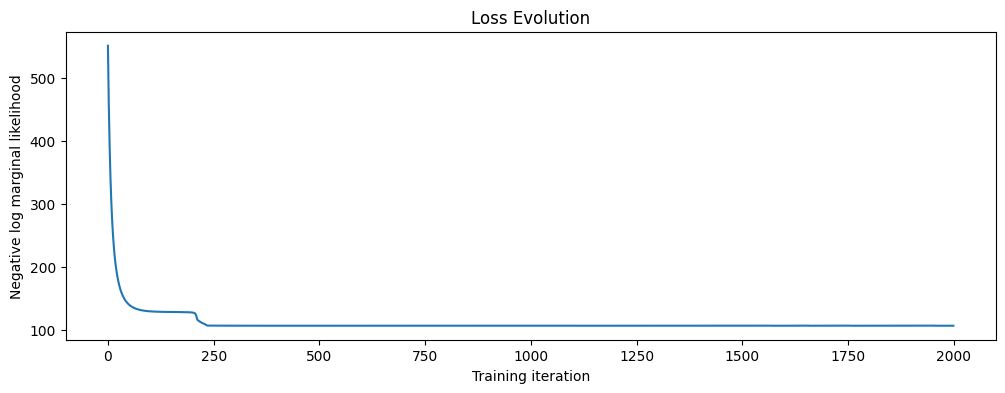

<function matplotlib.pyplot.show(close=None, block=None)>

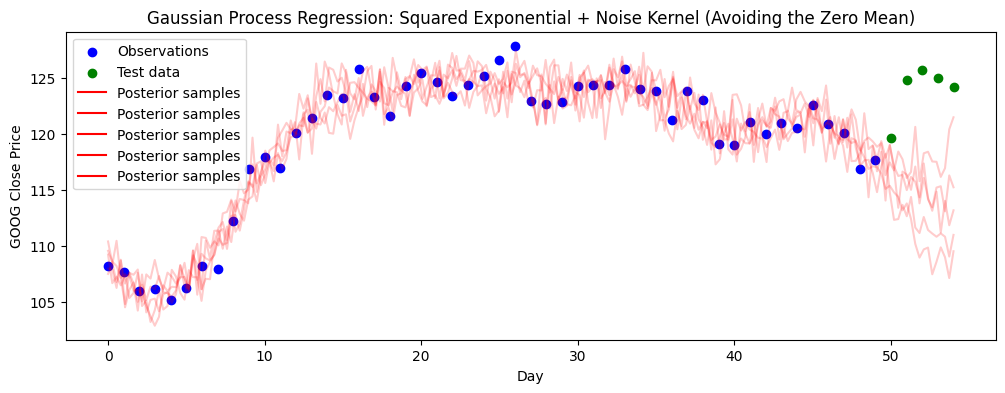

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1_new

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Noisy observation
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optomised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy() + y1.mean()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel (Avoiding the Zero Mean)')
plt.scatter(observation_index_points, y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters               Value
0                   amplitude   5.813671064640822
1                length_scale   5.309399169962551
2  observation_noise_variance  1.8516505034039374

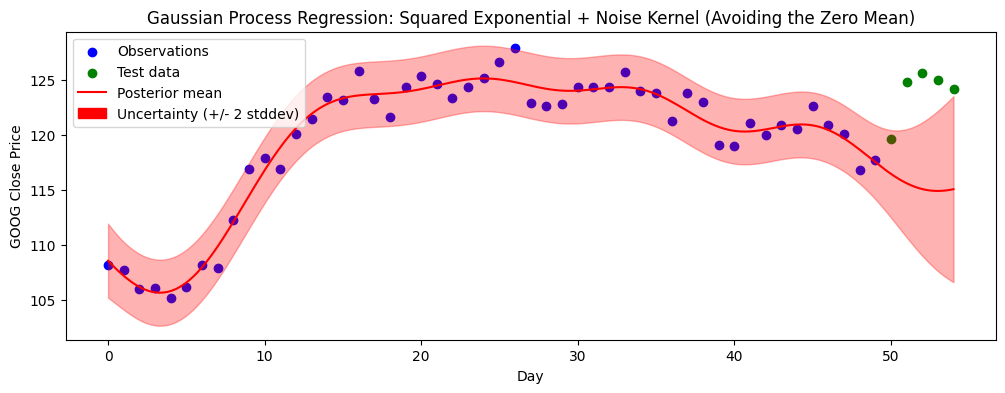

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean() + y1.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel (Avoiding the Zero Mean)')
plt.scatter(np.squeeze(observation_index_points), y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

To gain a more detailed understanding, let's extend the analysis, observing its behavior and the corresponding converging values in further test inputs.

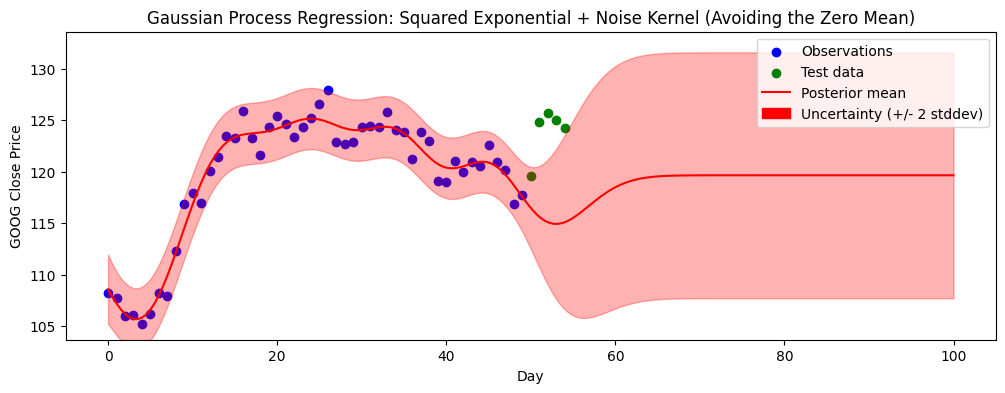

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean() + y1.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.ylim(tf.reduce_min(mean_prediction).numpy()-2, tf.reduce_max(mean_prediction + 2 * prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel (Avoiding the Zero Mean)')
plt.scatter(np.squeeze(observation_index_points), y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

We can see that the posterior mean now converges to the mean of the observations.

However, it is important to note that Gaussian processes are predominantly employed for near-future predictions in real-world scenarios, rather than for predictions extending far into the future.

### Standardisation

Step 0: NLL = 43.50847820836702
Step 100: NLL = 15.061769249602754
Step 200: NLL = 15.061769245657253
Step 300: NLL = 15.061769245657278
Step 400: NLL = 15.061769245657267
Step 500: NLL = 15.061769245657228
Step 600: NLL = 15.061775226103947
Step 700: NLL = 15.162532890412876
Step 800: NLL = 15.159475494917796
Step 900: NLL = 15.065183106723403
Step 1000: NLL = 15.061945395593945
Step 1100: NLL = 15.066310886117293
Step 1200: NLL = 15.170910220626904
Step 1300: NLL = 15.061914718954718
Step 1400: NLL = 15.061782475104515
Step 1500: NLL = 15.061769883191332
Step 1600: NLL = 15.061769305956084
Step 1700: NLL = 15.061770710332784
Step 1800: NLL = 15.061771907338237
Step 1900: NLL = 15.061770811909593
Final NLL = 15.061769280529589


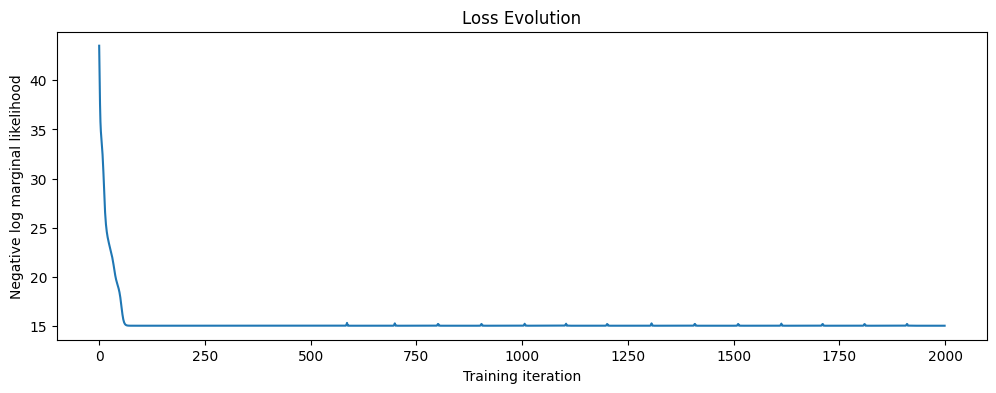

<function matplotlib.pyplot.show(close=None, block=None)>

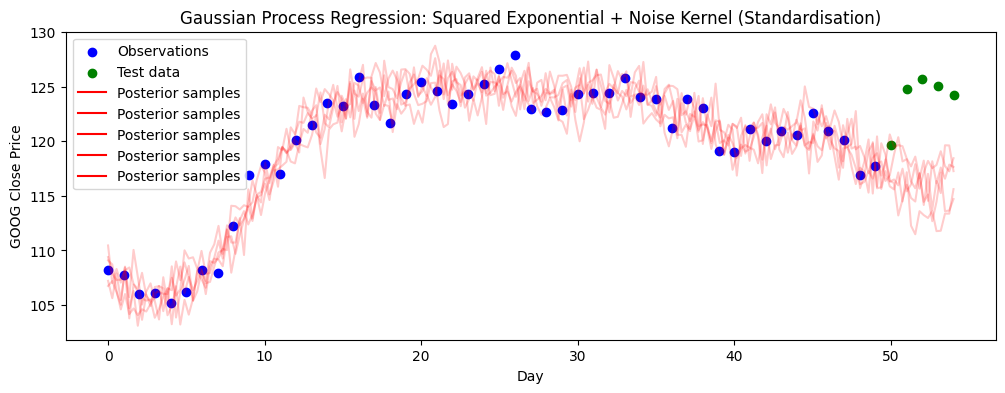

In [26]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y2

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Noisy observation
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optomised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()*std + av
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel (Standardisation)')
plt.scatter(observation_index_points, y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [27]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters                Value
0                   amplitude   0.9296768526436862
1                length_scale    5.309187360627931
2  observation_noise_variance  0.04734732419320784

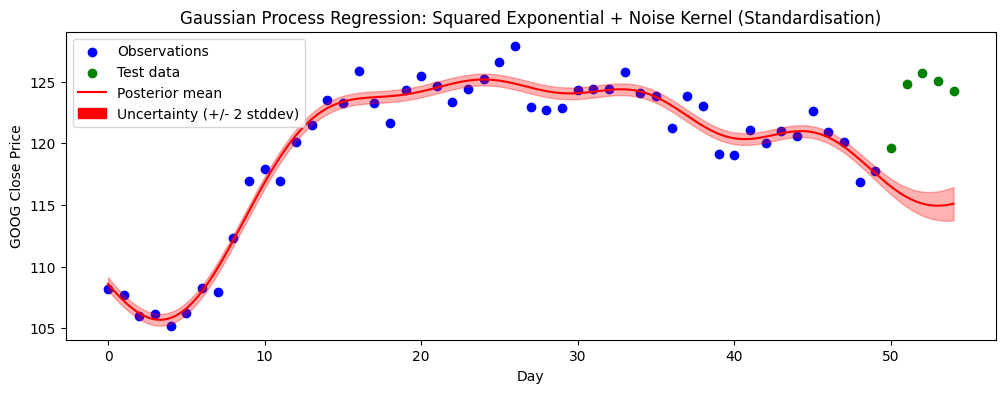

In [28]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean()*std + av, gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel (Standardisation)')
plt.scatter(np.squeeze(observation_index_points), y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

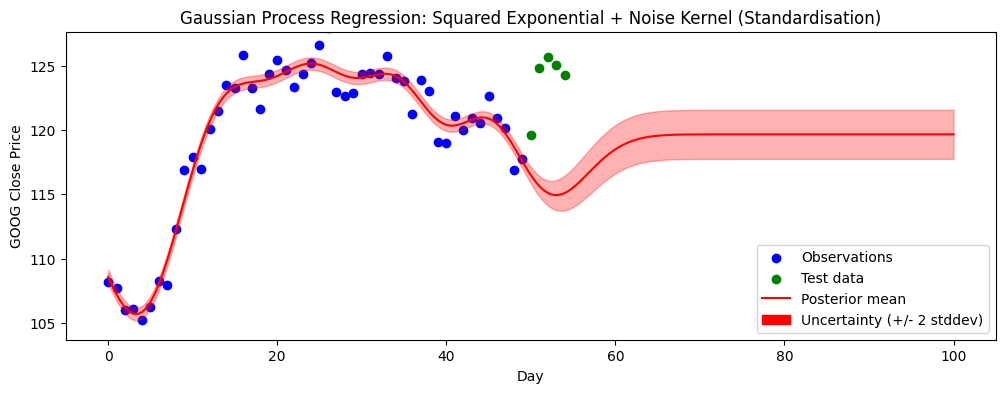

In [21]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean()*std + av, gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.ylim(tf.reduce_min(mean_prediction).numpy()-2, tf.reduce_max(mean_prediction + 2 * prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential + Noise Kernel (Standardisation)')
plt.scatter(np.squeeze(observation_index_points), y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='lower right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

## Exponentiated Quadratic Kernel with Linear Trend and Noise
Now we apply the squared exponential kernel with linear trend and noise to the noisy observations.

Step 0: NLL = 5952.718071166701
Step 100: NLL = 302.1153015922617
Step 200: NLL = 182.8530745194988
Step 300: NLL = 150.0992074588382
Step 400: NLL = 121.20103122413093
Step 500: NLL = 115.86794438607882
Step 600: NLL = 113.23739947394765
Step 700: NLL = 111.91963037846674
Step 800: NLL = 111.28523945559797
Step 900: NLL = 110.99561412441386
Step 1000: NLL = 110.88093209112549
Step 1100: NLL = 110.84656265600566
Step 1200: NLL = 110.84042711818063
Step 1300: NLL = 110.83999718111787
Step 1400: NLL = 110.83999009484057
Step 1500: NLL = 110.83998925633571
Step 1600: NLL = 110.83998876661394
Step 1700: NLL = 110.83998847440773
Step 1800: NLL = 110.83998829971773
Step 1900: NLL = 110.83998819458003
Final NLL = 110.83998813166596


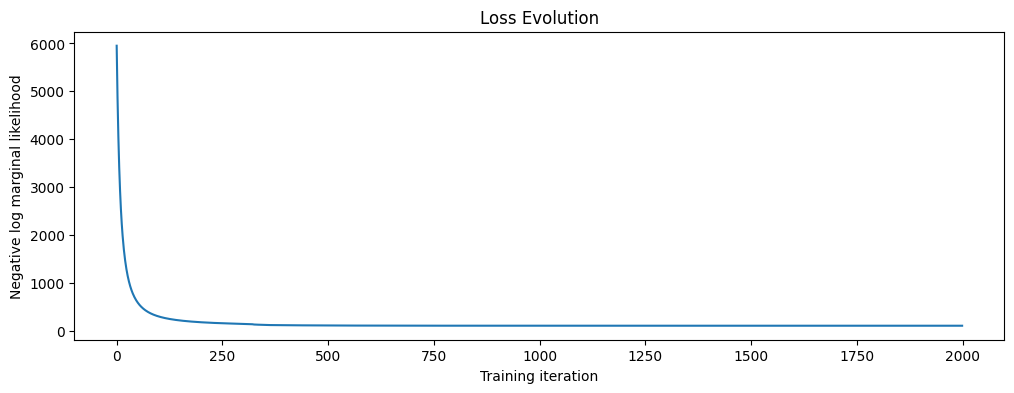

<function matplotlib.pyplot.show(close=None, block=None)>

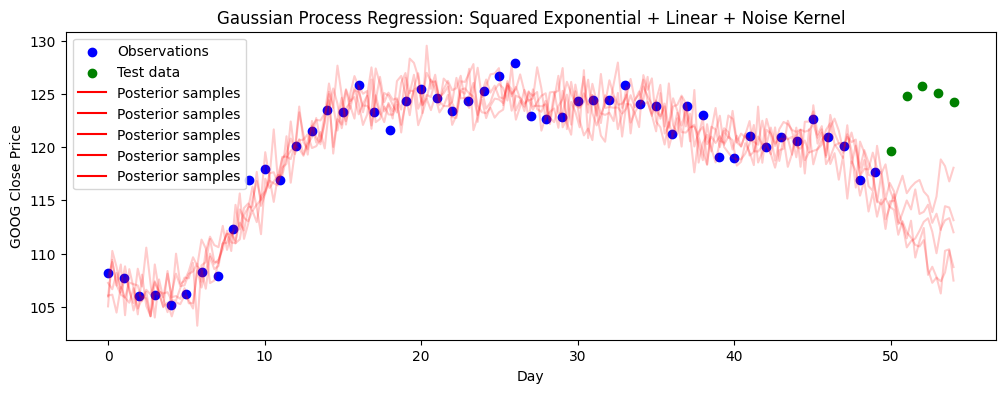

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define kernels with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.

# Squared exponential kernel
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Linear kernel
bias_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='bias_amplitude')
slope_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='slope_amplitude')
shift = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='shift')
kernel_linear = tfp.math.psd_kernels.Linear(bias_amplitude,slope_amplitude,shift)

# Combine the kernels together.
kernel = kernel_RBF+kernel_linear

# Noise kernel
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Noise Kernel')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    bias_amplitude,
    slope_amplitude,
    shift,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters                   Value
0                   amplitude       6.253122370501484
1                length_scale       5.476968960297615
2              bias_amplitude      118.25814581512384
3             slope_amplitude  0.00011508002187216806
4                       shift      0.2432800475576197
5  observation_noise_variance      1.8583781911566108

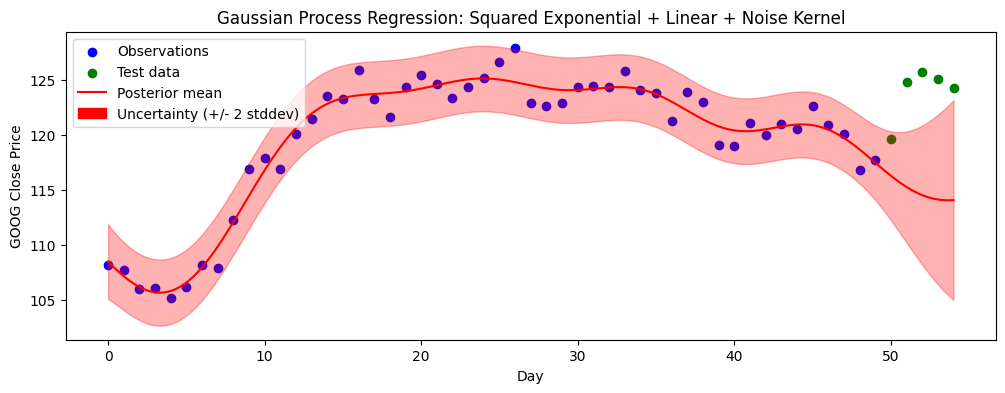

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Let's extend the analysis to gain a more detailed understanding of the behavior of the posterior mean and its associated converging values across additional test inputs.

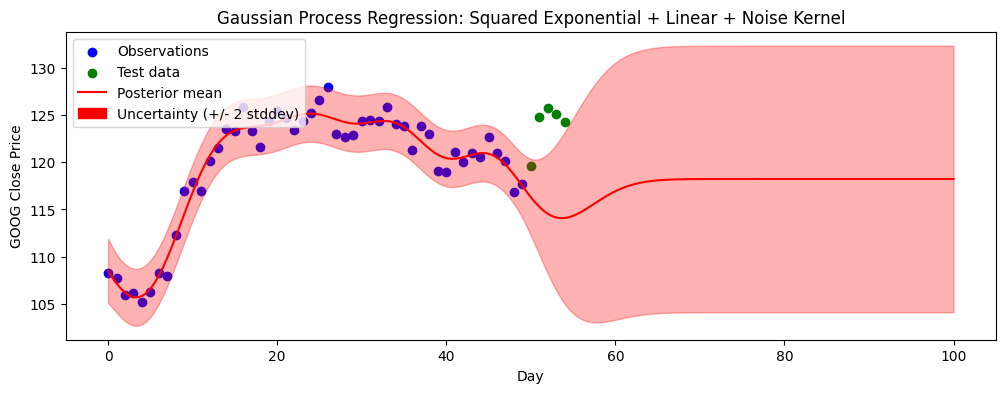

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

In [ ]:
observations.mean()

119.66510002

In [ ]:
mean_prediction[-1].numpy()

118.22109509236543

The figure suggests that the posterior mean of the Gaussian process regression model, when utilizing a squared exponential kernel combined with a linear trend and noise, tends to approach the mean of the observations for the test inputs. Consequently, it becomes more reasonable and effective to incorporate the linear kernel in order to make better predictions.

### Standardisation

Step 0: NLL = 46.298849684792174
Step 100: NLL = 15.142093167010085
Step 200: NLL = 15.074068085130648
Step 300: NLL = 15.066855557600348
Step 400: NLL = 15.064433799369752
Step 500: NLL = 15.0633116895041
Step 600: NLL = 15.062709387651477
Step 700: NLL = 15.062357513933478
Step 800: NLL = 15.062142070201073
Step 900: NLL = 15.062006566726783
Step 1000: NLL = 15.061920155082642
Step 1100: NLL = 15.061866938968329
Step 1200: NLL = 15.061950048784137
Step 1300: NLL = 15.061863988950787
Step 1400: NLL = 15.06179618811073
Step 1500: NLL = 15.061785738450624
Step 1600: NLL = 15.061780597694256
Step 1700: NLL = 15.06177469269307
Step 1800: NLL = 15.061772510811426
Step 1900: NLL = 15.061771231805462
Final NLL = 15.061770458977893


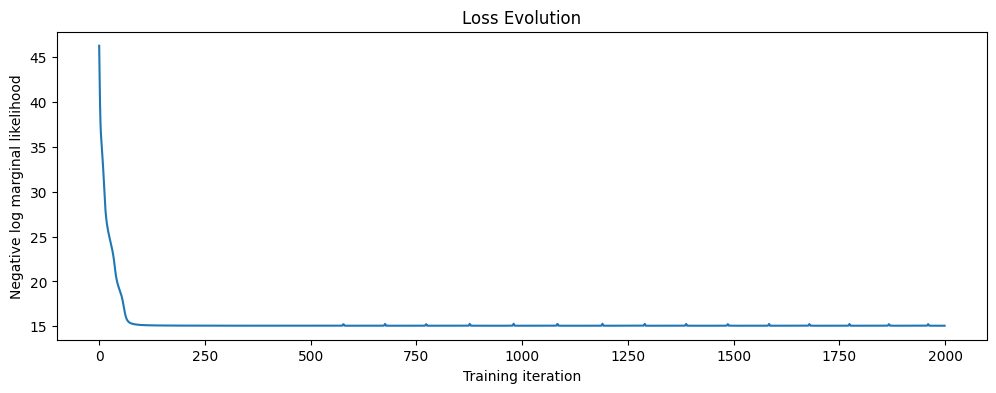

<function matplotlib.pyplot.show(close=None, block=None)>

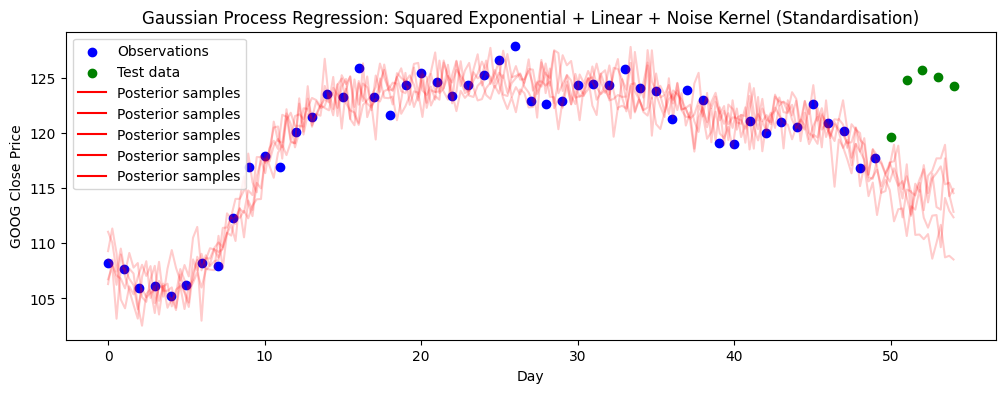

In [12]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y2

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define kernels with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.

# Squared exponential kernel
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Linear kernel
bias_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='bias_amplitude')
slope_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='slope_amplitude')
shift = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='shift')
kernel_linear = tfp.math.psd_kernels.Linear(bias_amplitude,slope_amplitude,shift)

# Combine the kernels together.
kernel = kernel_RBF+kernel_linear

# Noise kernel
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(5).numpy()*std + av
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Noise Kernel (Standardisation)')
plt.scatter(observation_index_points, y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [13]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    bias_amplitude,
    slope_amplitude,
    shift,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters                  Value
0                   amplitude     0.9296343740005405
1                length_scale      5.309381496788258
2              bias_amplitude  0.0002988247095168096
3             slope_amplitude  0.0001701210281256678
4                       shift     33.902945379638886
5  observation_noise_variance   0.047345486970048825

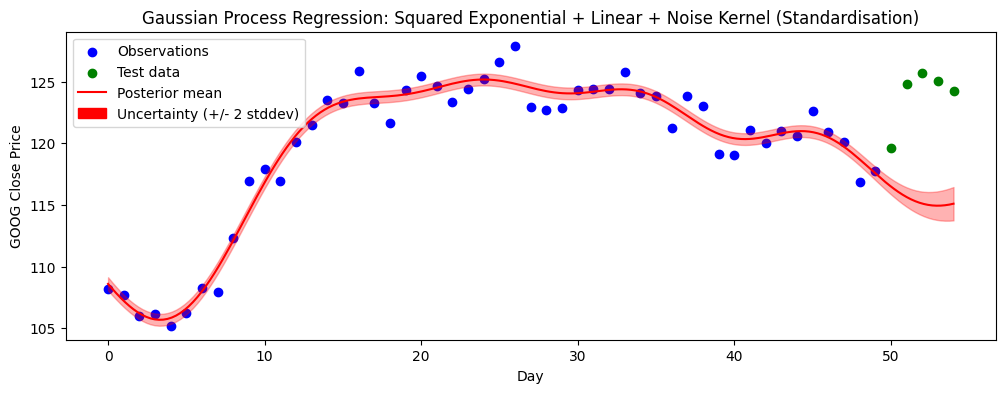

In [14]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean()*std + av, gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Noise Kernel (Standardisation)')
plt.scatter(np.squeeze(observation_index_points), y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

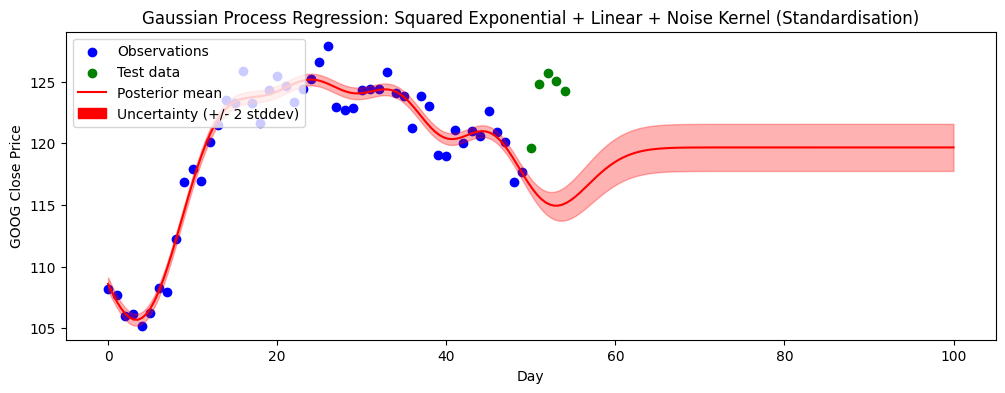

In [15]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean()*std + av, gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Noise Kernel (Standardisation)')
plt.scatter(np.squeeze(observation_index_points), y1, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

## Adding local periodic kernel

Step 0: NLL = 1320.96034889967
Step 100: NLL = 132.76883954024098
Step 200: NLL = 112.51363277967664
Step 300: NLL = 111.02652298470463
Step 400: NLL = 109.70132079419079
Step 500: NLL = 108.89779995122305
Step 600: NLL = 108.86684339396913
Step 700: NLL = 108.838958391023
Step 800: NLL = 108.83655050004104
Step 900: NLL = 108.83187913655291
Step 1000: NLL = 108.83525369879115
Step 1100: NLL = 108.83565965511343
Step 1200: NLL = 108.83637074518109
Step 1300: NLL = 108.83777093001413
Step 1400: NLL = 108.83846322372496
Step 1500: NLL = 108.83858380506706
Step 1600: NLL = 108.83855358996672
Step 1700: NLL = 108.83851486457755
Step 1800: NLL = 108.83848813743887
Step 1900: NLL = 108.83847029145643
Final NLL = 108.84556023551332


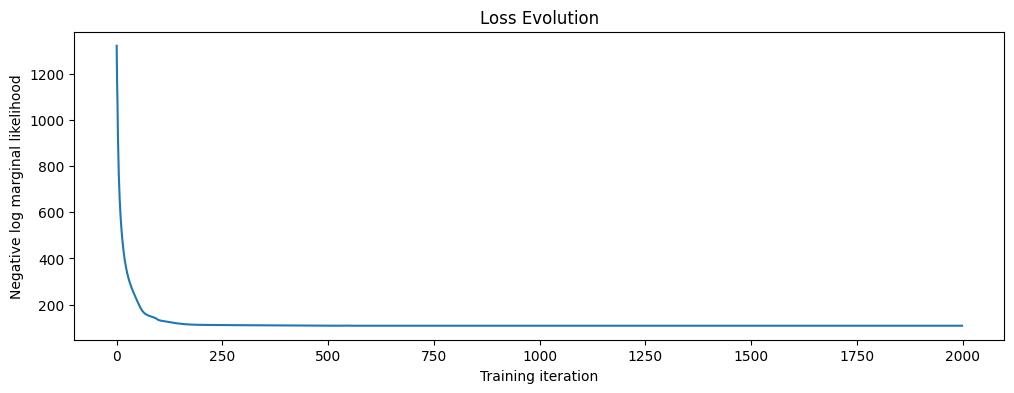

<function matplotlib.pyplot.show(close=None, block=None)>

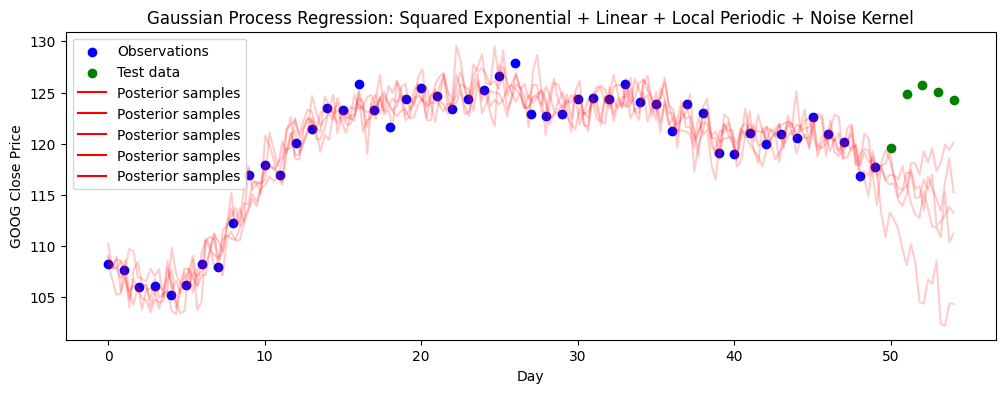

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define kernels with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.

# Squared exponential kernel
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Linear kernel
bias_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='bias_amplitude')
slope_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='slope_amplitude')
shift = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='shift')
kernel_linear = tfp.math.psd_kernels.Linear(bias_amplitude,slope_amplitude,shift)

# Local periodic kernel
periodic_amplitude = tfp.util.TransformedVariable(
    initial_value=5.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_amplitude')
periodic_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_length_scale')
periodic_period = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_period')
periodic_local_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_local_length_scale')
kernel_local_periodic = tfp.math.psd_kernels.ExpSinSquared(amplitude=periodic_amplitude, length_scale=periodic_length_scale, period=periodic_period) * tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=periodic_local_length_scale)

# Combine the kernels together.
kernel = kernel_RBF + kernel_linear + kernel_local_periodic

# Noise kernel
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Local Periodic + Noise Kernel')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    bias_amplitude,
    slope_amplitude,
    shift,
    periodic_amplitude,
    periodic_length_scale,
    periodic_period,
    periodic_local_length_scale,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters                Value
0                    amplitude   119.26708658140136
1                 length_scale    21038.29740193152
2               bias_amplitude   2.5381891746045784
3              slope_amplitude  0.03592737321126334
4                        shift   0.2693726008242175
5           periodic_amplitude    5.787701552684661
6        periodic_length_scale    7.059194322266753
7              periodic_period   1.2760414636684823
8  periodic_local_length_scale    4.941379404646903
9   observation_noise_variance    1.056711471764537

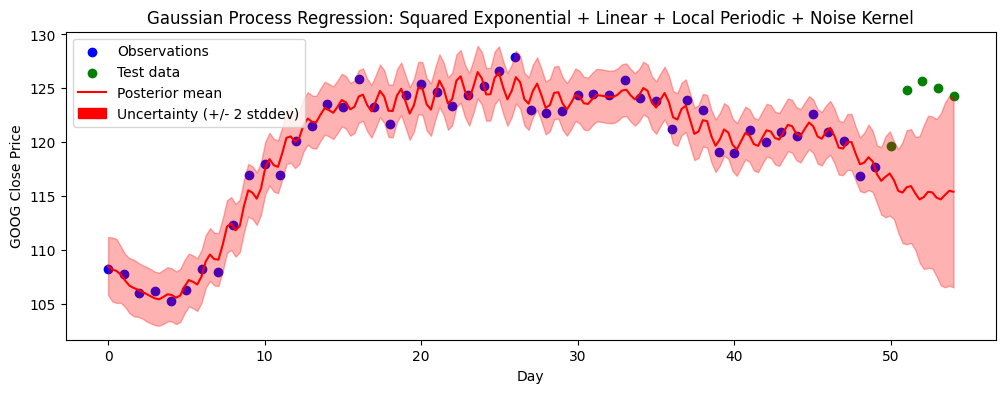

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Local Periodic + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

The posterior mean of the Gaussian process regression model using squared exponential kernel combined with linear trend, local periodic, and noise is fairly noisy, compared with the one without the local periodic.

Now let's expand the Day to see the converging value.

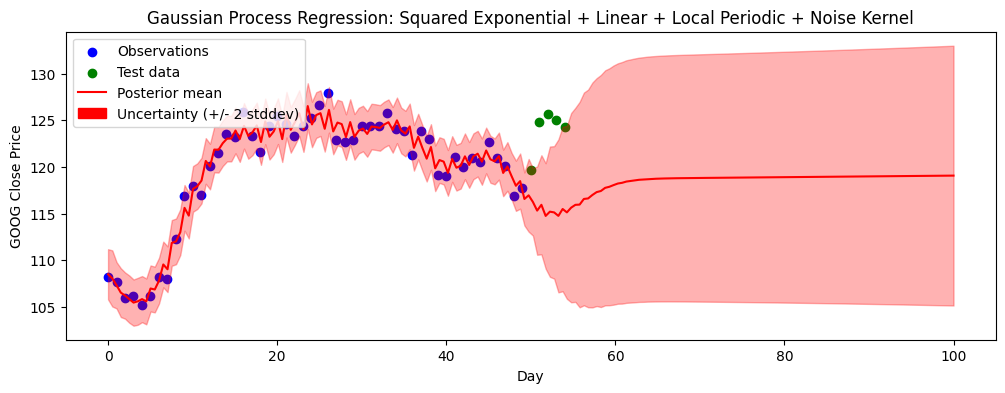

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Local Periodic + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Also, the posterior mean of the Gaussian process regression model using squared exponential kernel combined with linear trend, local periodic, and noise converges to the mean of the observations on the test inputs, and then and levels out.

## Adding a Short-medium Term Irregularities Kernel

Step 0: NLL = 1266.5175480277926
Step 100: NLL = 140.6662391490455
Step 200: NLL = 122.08239621490088
Step 300: NLL = 115.15503691660027
Step 400: NLL = 109.93373949384298
Step 500: NLL = 108.52481528744215
Step 600: NLL = 108.36859718246131
Step 700: NLL = 108.31945511996156
Step 800: NLL = 108.22693470658496
Step 900: NLL = 108.16042940920084
Step 1000: NLL = 108.15815205810455
Step 1100: NLL = 108.18032241321909
Step 1200: NLL = 108.15746334516326
Step 1300: NLL = 108.34503951750261
Step 1400: NLL = 108.1558299355423
Step 1500: NLL = 108.00274393702807
Step 1600: NLL = 108.00573459598428
Step 1700: NLL = 108.14684965134455
Step 1800: NLL = 108.11392887215116
Step 1900: NLL = 108.1073462189373
Final NLL = 108.1063792740745


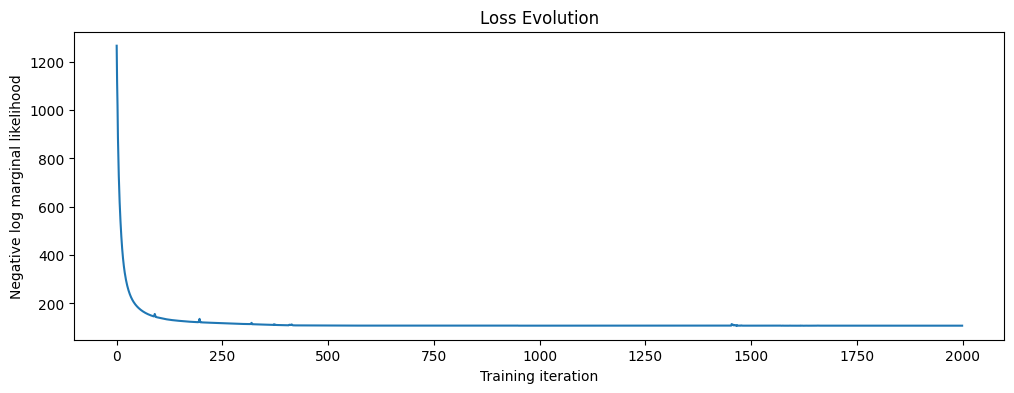

<function matplotlib.pyplot.show(close=None, block=None)>

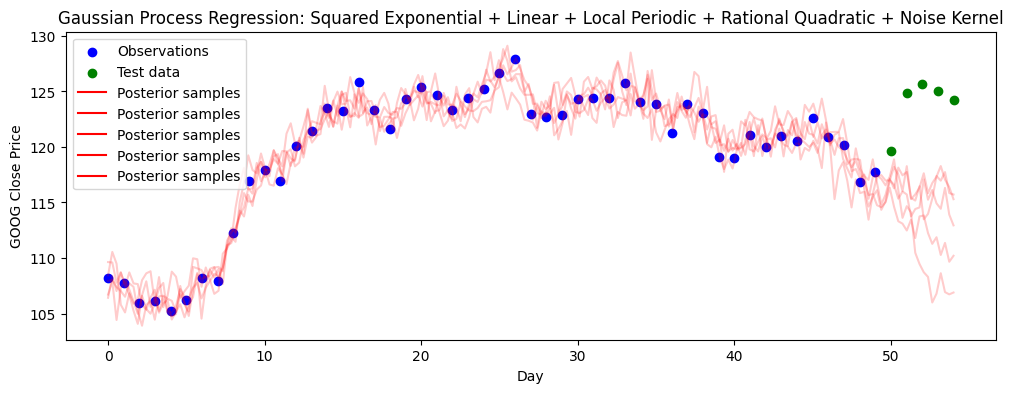

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define kernels with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.

# Squared exponential kernel
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Linear kernel
bias_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='bias_amplitude')
slope_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='slope_amplitude')
shift = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='shift')
kernel_linear = tfp.math.psd_kernels.Linear(bias_amplitude,slope_amplitude,shift)

# Local periodic kernel
periodic_amplitude = tfp.util.TransformedVariable(
    initial_value=5.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_amplitude')
periodic_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_length_scale')
periodic_period = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_period')
periodic_local_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_local_length_scale')
kernel_local_periodic = tfp.math.psd_kernels.ExpSinSquared(amplitude=periodic_amplitude, length_scale=periodic_length_scale, period=periodic_period) * tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=periodic_local_length_scale)

# Short-medium term irregularities kernel
irregular_amplitude = tfp.util.TransformedVariable(
    initial_value=1., bijector=tfb.Exp(), dtype=np.float64,
    name='irregular_amplitude')
irregular_length_scale = tfp.util.TransformedVariable(
    initial_value=1., bijector=tfb.Exp(), dtype=np.float64,
    name='irregular_length_scale')
irregular_scale_mixture = tfp.util.TransformedVariable(
    initial_value=1., bijector=tfb.Exp(), dtype=np.float64,
    name='irregular_scale_mixture')
kernel_irregular = tfp.math.psd_kernels.RationalQuadratic(amplitude=irregular_amplitude, length_scale=irregular_length_scale, scale_mixture_rate=irregular_scale_mixture)

# Combine the kernels together.
kernel = kernel_RBF + kernel_linear + kernel_local_periodic + kernel_irregular

# Noise kernel
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Local Periodic + Rational Quadratic + Noise Kernel')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    bias_amplitude,
    slope_amplitude,
    shift,
    periodic_amplitude,
    periodic_length_scale,
    periodic_period,
    periodic_local_length_scale,
    irregular_amplitude,
    irregular_length_scale,
    irregular_scale_mixture,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters                  Value
0                     amplitude     2.9866266391946708
1                  length_scale      4.344112986372634
2                bias_amplitude     1.4629525748157373
3               slope_amplitude  0.0024186210293291694
4                         shift    0.27080542490479864
5            periodic_amplitude      82.83237043891667
6         periodic_length_scale      207.2705460225913
7               periodic_period     1.0339100729621347
8   periodic_local_length_scale      72.17332202019114
9           irregular_amplitude     1.3774577037694467
10       irregular_length_scale      0.975429035926781
11      irregular_scale_mixture      293.2258817522386
12   observation_noise_variance     0.7238981703614865

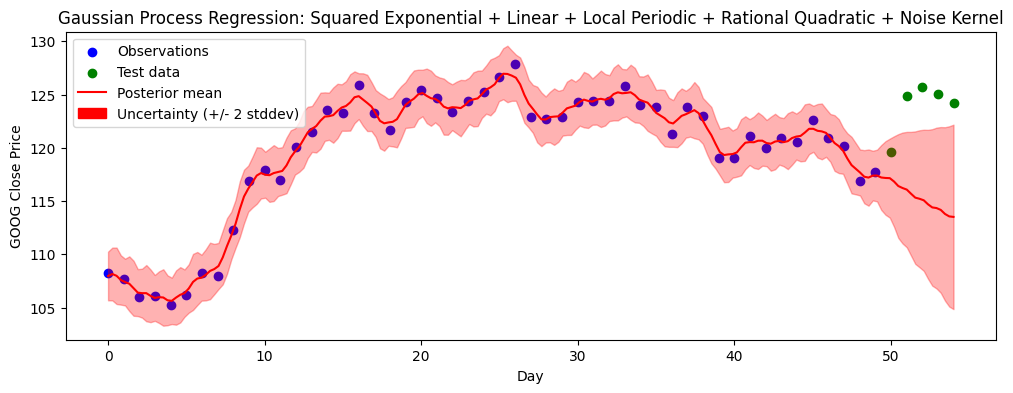

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Local Periodic + Rational Quadratic + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Let's expand the Day to see the converging value.

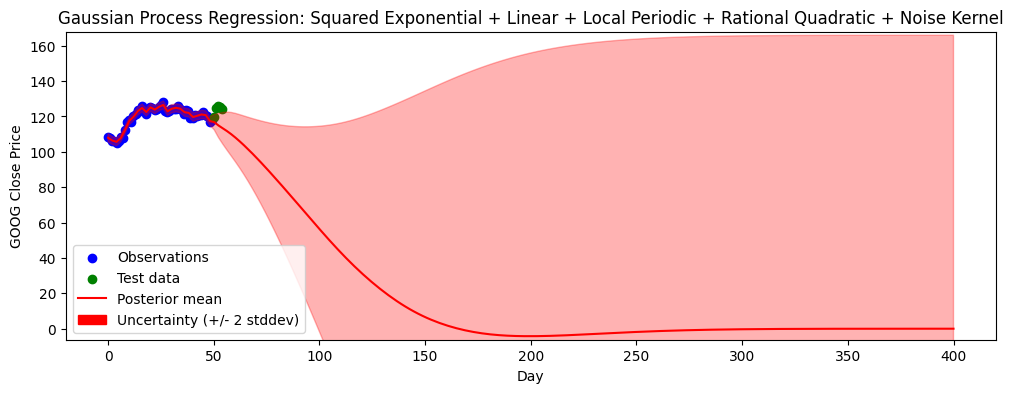

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 400, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.ylim(tf.reduce_min(mean_prediction).numpy()-2, tf.reduce_max(mean_prediction + 2 * prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Local Periodic + Rational Quadratic + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='lower left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Surprisingly, the posterior mean of the Gaussian process using squared exponential kernel combined with linear trend, local periodic, short-medium term irregularities, and noise tends to converge to 0 although the linear kernel is included.

## Squared Exponential + Local Periodic + Rational Quadratic + Noise Kernel
Now we try using the kernel introduced in the Mauna Loa Atmospheric Carbon Dioxide example by Rasmussen & Williams (2006, pp.118-1220). The combined kernel consisted of a squared exponential, local periodic, rational quadratic, and noise kernels (no linear kerneal).

Step 0: NLL = 5423.2367380223495
Step 100: NLL = 156.59822264764526
Step 200: NLL = 129.93125810017537
Step 300: NLL = 122.15410287137775
Step 400: NLL = 114.36063062675689
Step 500: NLL = 112.79688351870578
Step 600: NLL = 111.09389007110963
Step 700: NLL = 107.99059952329262
Step 800: NLL = 107.7607398313356
Step 900: NLL = 107.657606087781
Step 1000: NLL = 107.61351895249197
Step 1100: NLL = 107.58860162698883
Step 1200: NLL = 107.52329582666533
Step 1300: NLL = 107.51739101495718
Step 1400: NLL = 107.52976649777543
Step 1500: NLL = 107.51467348569761
Step 1600: NLL = 107.55227498246597
Step 1700: NLL = 107.55736891526459
Step 1800: NLL = 107.54532094369446
Step 1900: NLL = 107.56796209639518
Final NLL = 107.52806353127889


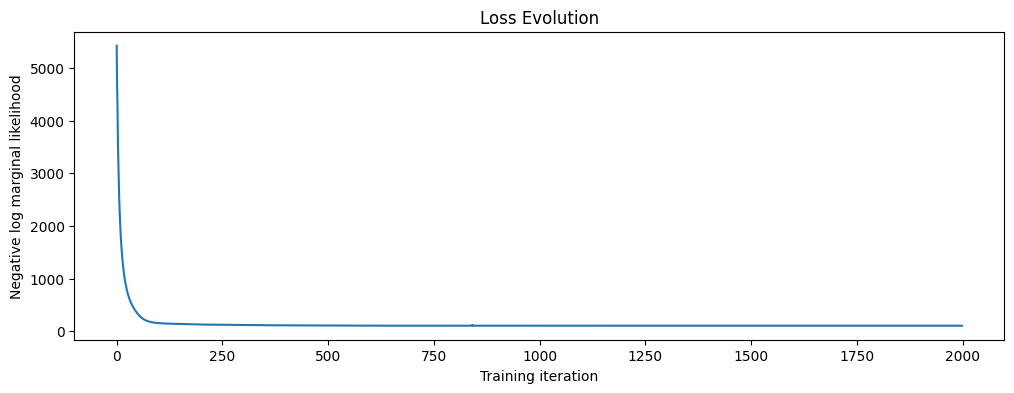

<function matplotlib.pyplot.show(close=None, block=None)>

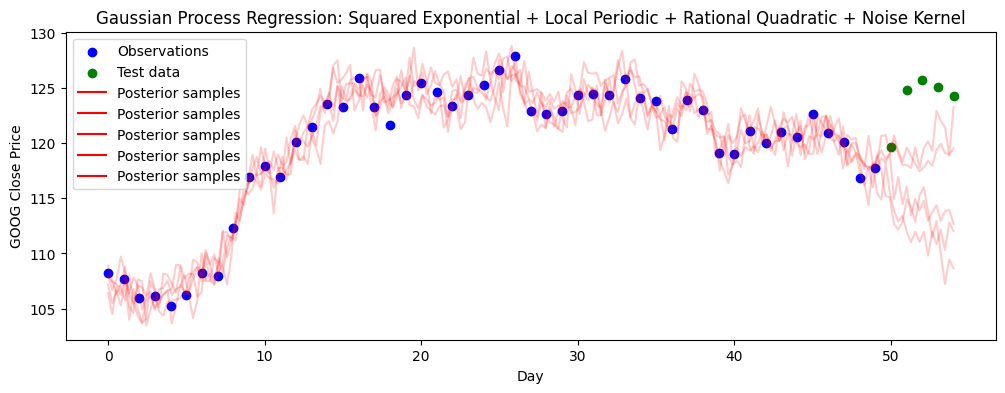

In [29]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define kernels with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.

# Squared exponential kernel
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Local periodic kernel
periodic_amplitude = tfp.util.TransformedVariable(
    initial_value=5.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_amplitude')
periodic_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_length_scale')
periodic_period = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_period')
periodic_local_length_scale = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=tfb.Exp(), dtype=np.float64,
    name='periodic_local_length_scale')
kernel_local_periodic = tfp.math.psd_kernels.ExpSinSquared(amplitude=periodic_amplitude, length_scale=periodic_length_scale, period=periodic_period) * tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=periodic_local_length_scale)

# Short-medium term irregularities kernel
irregular_amplitude = tfp.util.TransformedVariable(
    initial_value=1., bijector=tfb.Exp(), dtype=np.float64,
    name='irregular_amplitude')
irregular_length_scale = tfp.util.TransformedVariable(
    initial_value=1., bijector=tfb.Exp(), dtype=np.float64,
    name='irregular_length_scale')
irregular_scale_mixture = tfp.util.TransformedVariable(
    initial_value=1., bijector=tfb.Exp(), dtype=np.float64,
    name='irregular_scale_mixture')
kernel_irregular = tfp.math.psd_kernels.RationalQuadratic(amplitude=irregular_amplitude, length_scale=irregular_length_scale, scale_mixture_rate=irregular_scale_mixture)

# Combine the kernels together.
kernel = kernel_RBF + kernel_local_periodic + kernel_irregular

# Noise kernel
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Local Periodic + Rational Quadratic + Noise Kernel')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [30]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    periodic_amplitude,
    periodic_length_scale,
    periodic_period,
    periodic_local_length_scale,
    irregular_amplitude,
    irregular_length_scale,
    irregular_scale_mixture,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters                 Value
0                    amplitude     1.392240413474956
1                 length_scale    1.0136574206626126
2           periodic_amplitude     7.025470472018277
3        periodic_length_scale    10.257579848699585
4              periodic_period    0.9363041883407252
5  periodic_local_length_scale      8.45799337921119
6          irregular_amplitude    118.20673621896773
7       irregular_length_scale     35419.15429962776
8      irregular_scale_mixture  0.027758998197909102
9   observation_noise_variance    0.7458458612394758

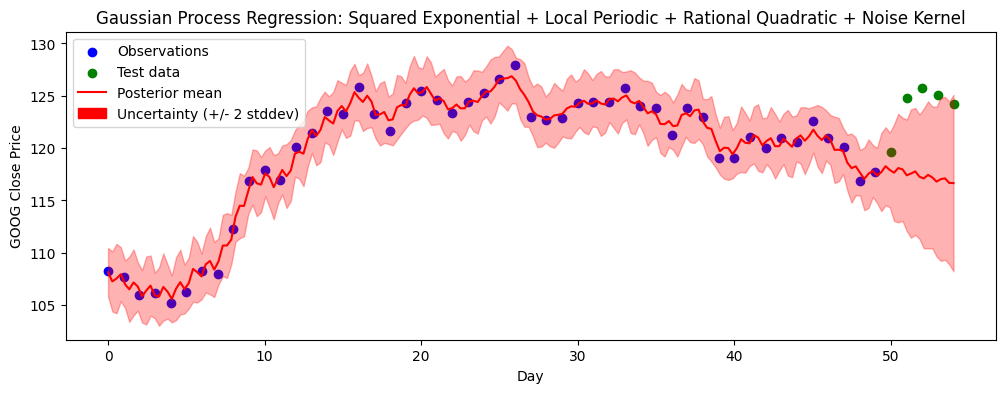

In [31]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Local Periodic + Rational Quadratic + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Let's expand the Day to see the converging value.

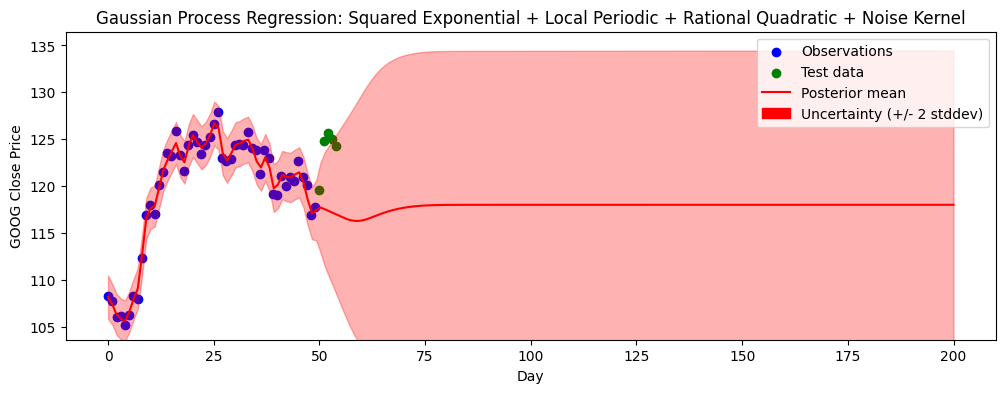

In [34]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 200, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.ylim(tf.reduce_min(mean_prediction).numpy()-2, tf.reduce_max(mean_prediction + 2 * prediction_stddev).numpy()+2)
plt.title('Gaussian Process Regression: Squared Exponential + Local Periodic + Rational Quadratic + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

It is intriguing to note that the posterior mean of the Gaussian process, incorporating the squared exponential kernel along with local periodic, short-medium term irregularities, and noise kernels, tends to converge towards the mean of the observations even when the linear kernel is omitted. However, the interpolation posterior mean exhibits noticeable fluctuations.

## Considering the Constant Kernel
Now we add a constant kernel to the above kernels and see how it impacts on the posterior distribution.

In [ ]:
# Define a constant kernel.
constant = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='constant')
kernel_constant = tfp.math.psd_kernels.Constant(constant)

In [ ]:
# Combine kernels together
kernel = kernel + kernel_constant

### Squared Exponential + Constant Kernels without Noise

Step 0: NLL = 7375.007705750118
Step 100: NLL = 274.6837765691978
Step 200: NLL = 223.53524455215057
Step 300: NLL = 220.94651533602817
Step 400: NLL = 220.8144289584697
Step 500: NLL = 220.81203939399884
Step 600: NLL = 220.81208854938805
Step 700: NLL = 220.81226369461862
Step 800: NLL = 220.81254123282397
Step 900: NLL = 220.81275500502218
Step 1000: NLL = 220.81145523833376
Step 1100: NLL = 220.80243509141354
Step 1200: NLL = 220.77101102006029
Step 1300: NLL = 220.6745737100388
Step 1400: NLL = 219.92394016657175
Step 1500: NLL = 134.20710325377823
Step 1600: NLL = 133.83468656062809
Step 1700: NLL = 133.80725878564598
Step 1800: NLL = 133.806069422958
Step 1900: NLL = 133.88169330732572
Final NLL = 133.83340987204514


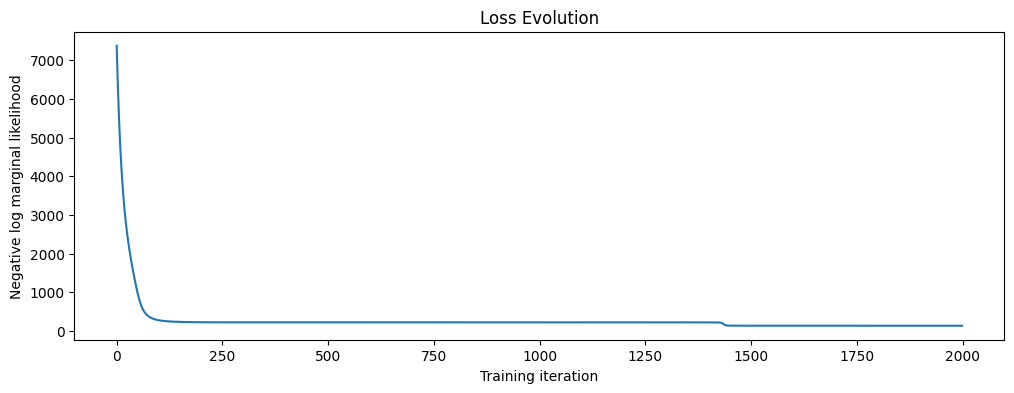

<function matplotlib.pyplot.show(close=None, block=None)>

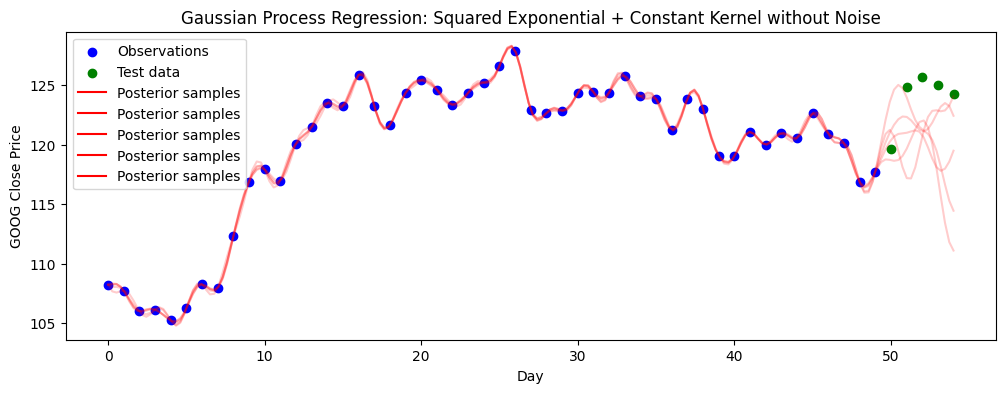

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Define a constant kernel.
constant = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='constant')
kernel_constant = tfp.math.psd_kernels.Constant(constant)

# Combine kernels together
kernel = kernel_RBF + kernel_constant

# Noise-free observation
observation_noise_variance = 0.0

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

# The parameters beta_1 and beta_2 are the exponential decay rates for
# the first and second moments of the gradient, respectively.
# They control the weight given to past gradients and squared gradients
# in the parameter updates.
optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Constant Kernel without Noise')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    constant
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
para.append(('observation_noise_variance', np.array(observation_noise_variance)))
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters               Value
0                   amplitude   5.092005381957294
1                length_scale   1.118428197500873
2                    constant  14280.124896088722
3  observation_noise_variance                 0.0

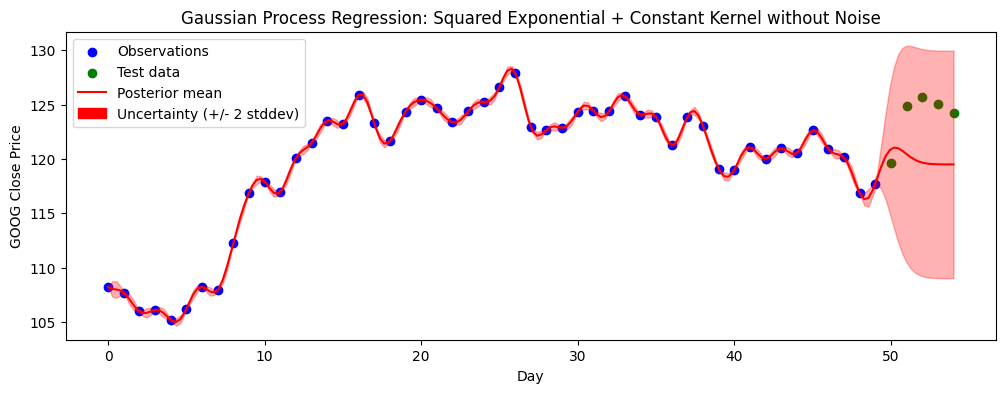

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Constant Kernel without Noise')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Let's increase the Index.

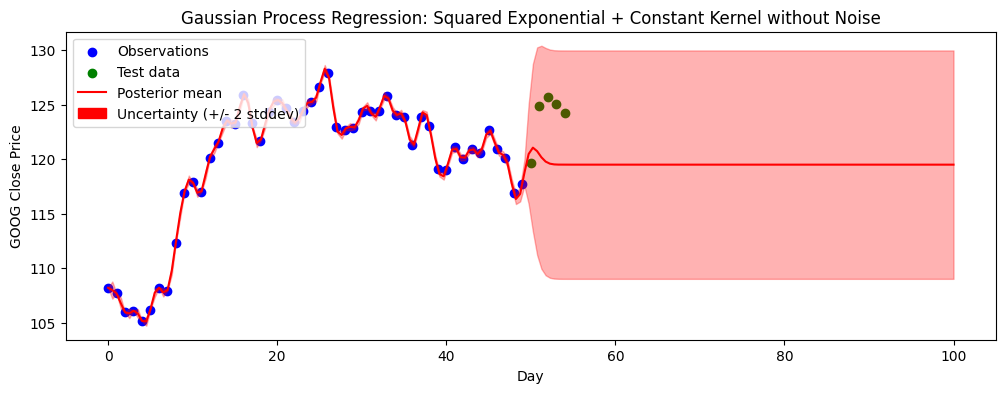

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Constant Kernel without Noise')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

In [ ]:
observations.mean()

119.66510002

In [ ]:
mean_prediction[-1].numpy()

119.49354237308171

We can see that adding the constant kernel pretend the posterior mean to converge to 0. Instead, it converge to the mean of the observations.

### Squared Exponential + Constant Kernels with Noise

Step 0: NLL = 7361.93785641037
Step 100: NLL = 177.06503735105065
Step 200: NLL = 130.6842292376837
Step 300: NLL = 123.29064748292075
Step 400: NLL = 121.15569378958455
Step 500: NLL = 120.51403760808594
Step 600: NLL = 120.35930390693477
Step 700: NLL = 120.33762716922058
Step 800: NLL = 120.33656651819089
Step 900: NLL = 120.33796217395596
Step 1000: NLL = 120.3365855654595
Step 1100: NLL = 120.33655587723482
Step 1200: NLL = 120.33655343986464
Step 1300: NLL = 120.33684751710518
Step 1400: NLL = 120.33654279217714
Step 1500: NLL = 120.33653148371991
Step 1600: NLL = 120.33651362317465
Step 1700: NLL = 120.33648055333526
Step 1800: NLL = 120.33642524055307
Step 1900: NLL = 120.33692941653274
Final NLL = 120.3361399568449


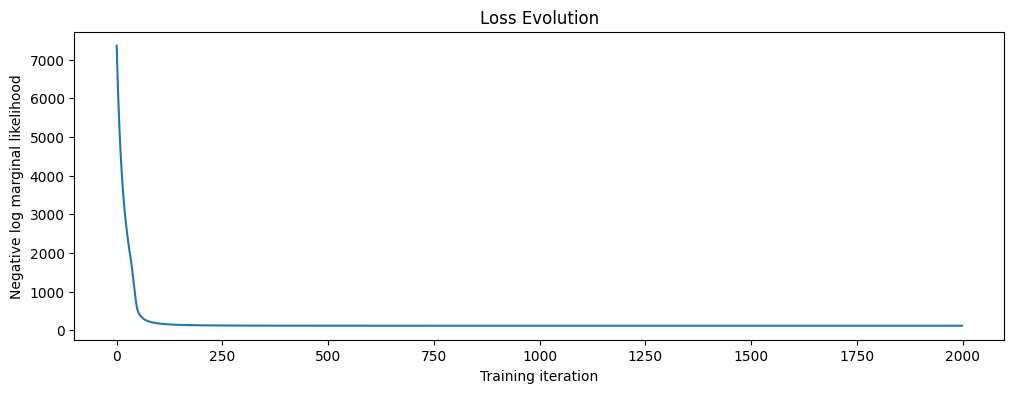

<function matplotlib.pyplot.show(close=None, block=None)>

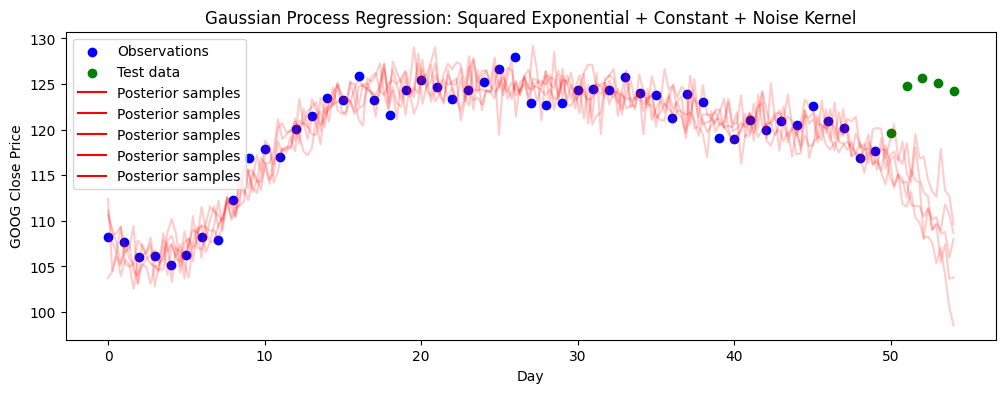

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define a kernel with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Define a constant kernel.
constant = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='constant')
kernel_constant = tfp.math.psd_kernels.Constant(constant)

# Combine kernels together
kernel = kernel_RBF + kernel_constant

# Noisy observation
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optomised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain 5 posterior samples.
samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Constant + Noise Kernel')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    constant,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters               Value
0                   amplitude   96.08328438501566
1                length_scale  13.520939399653365
2                    constant   4.667198953517119
3  observation_noise_variance  2.1868904121219046

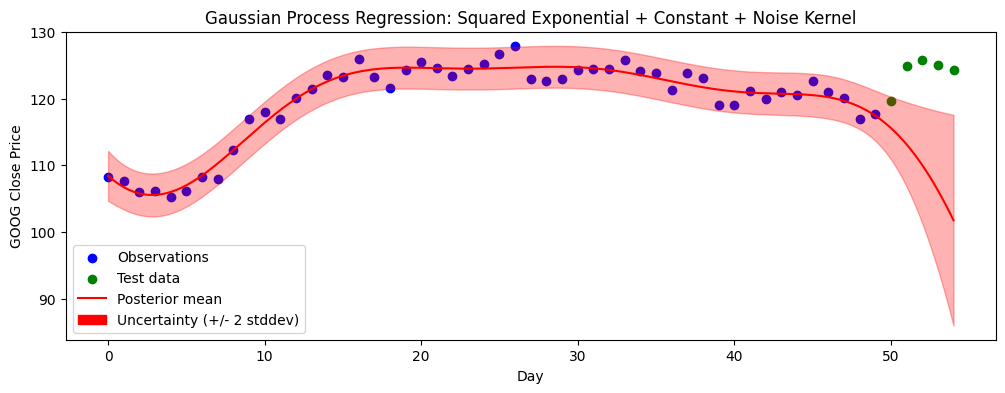

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Constant + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='lower left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Let's increase the test inputs.

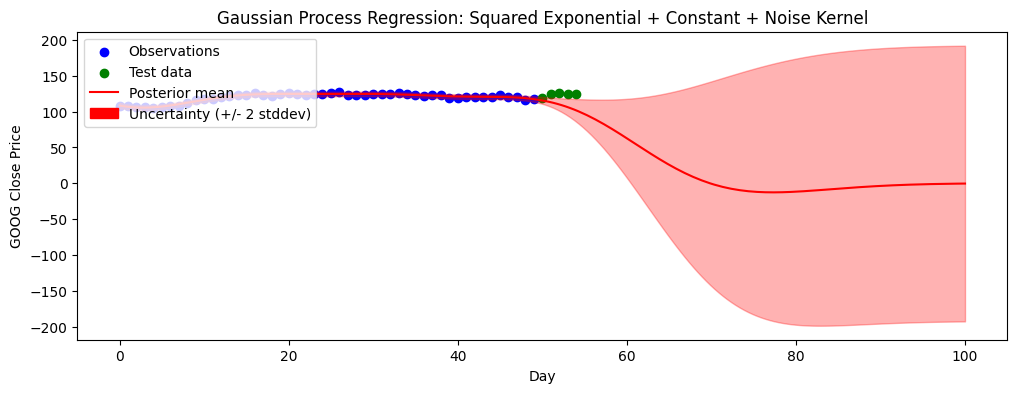

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Constant + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

In [ ]:
mean_prediction[-1].numpy()

-0.32810955413261045

It can be seen that adding the constant kernel does not impact on the converging value of the posterior mean. It is still zero.

### Squared Exponential + Linear + Constant Kernels with Noise

Step 0: NLL = 3408.355381025054
Step 100: NLL = 203.39674570191542
Step 200: NLL = 147.4115599738968
Step 300: NLL = 118.49888863795258
Step 400: NLL = 114.1104607286943
Step 500: NLL = 112.2254601148208
Step 600: NLL = 111.39639157092716
Step 700: NLL = 111.0353429725688
Step 800: NLL = 110.8934707149775
Step 900: NLL = 110.84929613638744
Step 1000: NLL = 110.84073611652835
Step 1100: NLL = 110.840021959424
Step 1200: NLL = 110.84000064139195
Step 1300: NLL = 110.83999549971949
Step 1400: NLL = 110.83999250069417
Step 1500: NLL = 110.83999071698864
Step 1600: NLL = 110.83998965159975
Step 1700: NLL = 110.83998901115257
Step 1800: NLL = 110.83998862494195
Step 1900: NLL = 110.83998839161694
Final NLL = 110.83998825163249


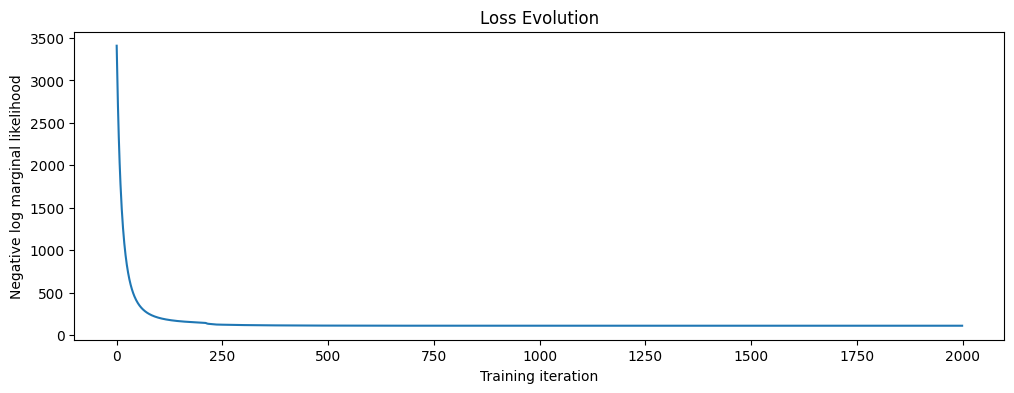

<function matplotlib.pyplot.show(close=None, block=None)>

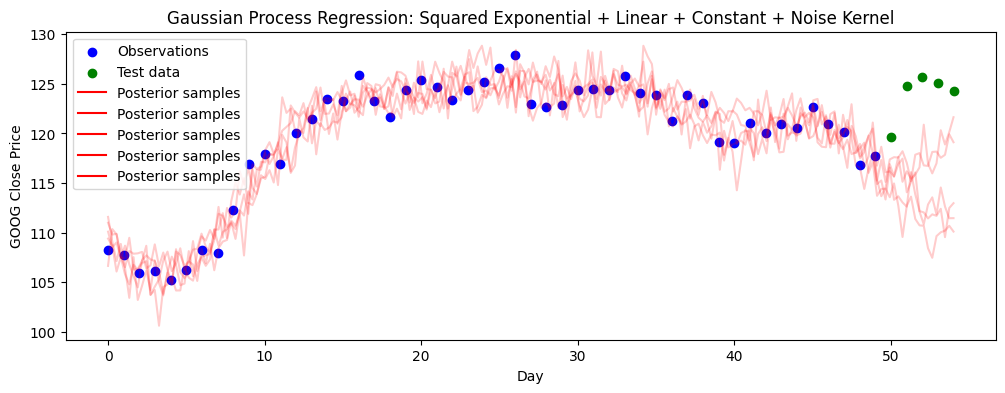

In [ ]:
# We build the observations to be a function f(x) where f(x) is the target values (Close Price) and x is the days.
# Note the index points in general have shape `[b1, ..., bB, f1, ..., fF]` (here we assume `F == 1`),
# so we need to explicitly consume the feature dimensions (just the last one here).
f = lambda x: y1

observation_index_points = x1.reshape(-1,1)
observations = f(observation_index_points)

# Define kernels with trainable parameters. Note we use TransformedVariable
# to apply a positivity constraint.

# Squared exponential kernel
amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel_RBF = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

# Linear kernel
bias_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='bias_amplitude')
slope_amplitude = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='slope_amplitude')
shift = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='shift')
kernel_linear = tfp.math.psd_kernels.Linear(bias_amplitude,slope_amplitude,shift)

# Define a constant kernel.
constant = tfp.util.TransformedVariable(
  1., tfb.Exp(), dtype=tf.float64, name='constant')
kernel_constant = tfp.math.psd_kernels.Constant(constant)

# Combine the kernels together.
kernel = kernel_RBF + kernel_linear + kernel_constant

# Noise kernel
observation_noise_variance = tfp.util.TransformedVariable(
    np.exp(-5), tfb.Exp(), name='observation_noise_variance')

# We will use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)

@tf.function
def optimize():
  with tf.GradientTape() as tape:
    loss = -gp.log_prob(observations)
  grads = tape.gradient(loss, gp.trainable_variables)
  optimizer.apply_gradients(zip(grads, gp.trainable_variables))
  return loss

# First train the model, then draw and plot posterior samples.
loss = []
for i in range(2000):
  neg_log_likelihood_ = optimize()
  loss.append(neg_log_likelihood_)
  if i % 100 == 0:
    print("Step {}: NLL = {}".format(i, neg_log_likelihood_))

print("Final NLL = {}".format(neg_log_likelihood_))

# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.title('Loss Evolution')
plt.plot(loss)
plt.xlabel("Training iteration")
plt.ylabel("Negative log marginal likelihood")
plt.show()

# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 54, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(5).numpy()
# ==> 5 independently drawn, joint samples at `index_points`.

# Plot the postrior samples.
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Constant + Noise Kernel')
plt.scatter(observation_index_points, observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, samples.T, c='r', alpha=.2, label='Posterior samples')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show

In [ ]:
# Show values of the optimised parameters
variables = [
    amplitude,
    length_scale,
    bias_amplitude,
    slope_amplitude,
    shift,
    constant,
    observation_noise_variance
]

para = list([(var.variables[0].name[:-2], var.numpy()) for var in variables])
hyperpara = pd.DataFrame(
    para, columns=['Hyperparameters', 'Value'])
hyperpara
# display(HTML(hyperpara.to_html(
#     index=False, float_format=lambda x: f'{x:.4f}')))

Hyperparameters                   Value
0                   amplitude       6.253122591886017
1                length_scale        5.47696845249886
2              bias_amplitude      118.24678544446336
3             slope_amplitude  0.00017122459565566874
4                       shift      0.2776175534812891
5                    constant      2.6863717950997277
6  observation_noise_variance       1.858378296233393

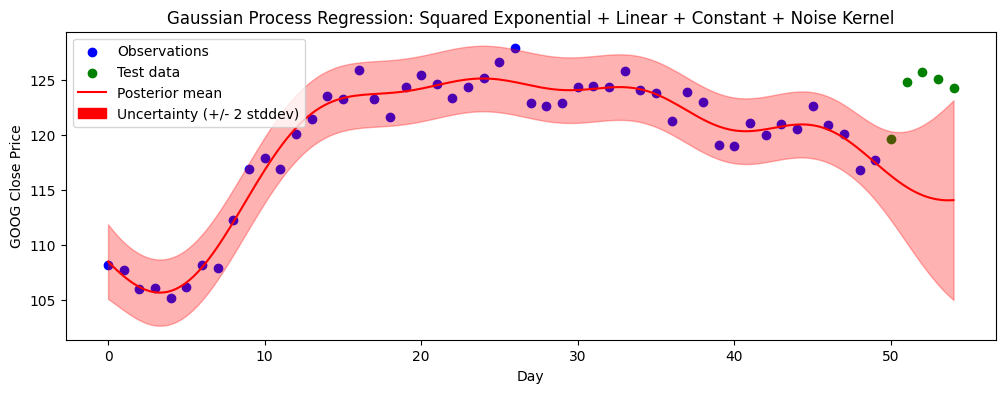

In [ ]:
# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Constant + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

Let's increase the test inputs.

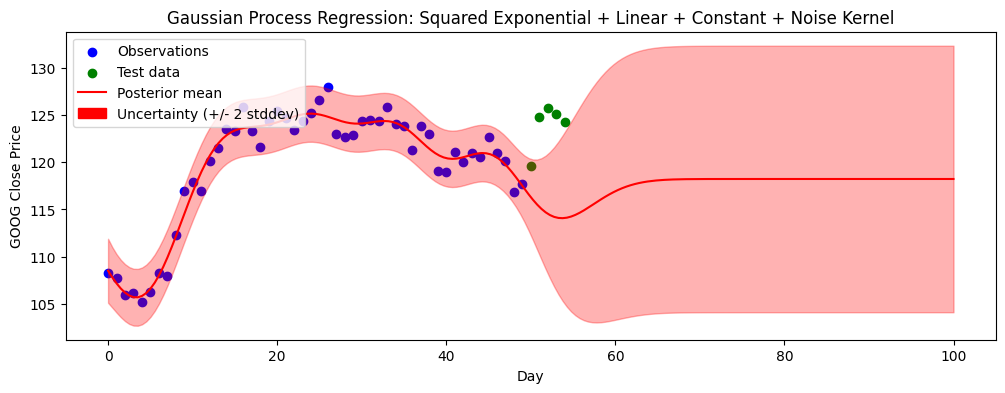

In [ ]:
# We can construct the posterior at a new set of `index_points` using the same
# kernel (with the optimised parameters, which we optimised above).
predictive_index_points_ = np.linspace(0, 100, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

# Define a Gaussian linear regression model for estimating the posterior
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

# Obtain the posterior mean and standard deviation
mean_prediction, prediction_stddev = gprm.mean(), gprm.stddev()

# Plot the observed data points
plt.figure(figsize=(12, 4))
plt.title('Gaussian Process Regression: Squared Exponential + Linear + Constant + Noise Kernel')
plt.scatter(np.squeeze(observation_index_points), observations, c='b', label='Observations')
plt.scatter(xt, yt, c='g', label='Test data')
plt.plot(predictive_index_points_, mean_prediction, color='red', label='Posterior mean')
# Fill the region between mean - 2 * stddev and mean + 2 * stddev for uncertainty visualization
plt.fill_between(
    predictive_index_points_.reshape(-1),
    (mean_prediction - 2 * prediction_stddev).numpy().reshape(-1),
    (mean_prediction + 2 * prediction_stddev).numpy().reshape(-1),
    color='red',
    alpha=0.3,
    label='Uncertainty (+/- 2 stddev)')
leg = plt.legend(loc='upper left')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel("Day")
plt.ylabel("GOOG Close Price")
plt.show()

In [ ]:
mean_prediction[-1].numpy()

118.22110077958769

The posterior mean still converges to the mean of the observations. Hence, adding the constant kernel does not significantly improve the posterior mean.